# Predcition of Hospital Admission Related to Pneumonia

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to pneumonia.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'pneumonia_date_'+str(i), 'pneumonia_ab_date_'+str(i), 'pneumonia_ab_type_'+str(i),
                   'incdt_pneumonia_date_'+str(i), 'admitted_pneumonia_date_'+str(i), 'sgss_gp_cov_pneumonia_date_'+str(i)]]
    
    #drop rows with no pneumonia reord
    datum = datum[datum['pneumonia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with pneumonia_i
    datum = datum[datum['sgss_gp_cov_pneumonia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'pneumonia_date_'+str(i): 'pneumonia_date', 'pneumonia_ab_date_'+str(i): 'pneumonia_ab_date', 
                           'pneumonia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_pneumonia_date_'+str(i): 'incdt_pneumonia_date', 'incdt_pneumonia_type_'+str(i): 'incdt_pneumonia_type',
                           'admitted_pneumonia_date_'+str(i): 'admitted_pneumonia_date',
                           'sgss_gp_cov_pneumonia_date_'+str(i): 'sgss_gp_cov_pneumonia_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_pneumonia.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 pneumonias and concatenate them 
data_pneumonia_1 = proc_infec_data(data,1)
data_pneumonia_2 = proc_infec_data(data,2)
data_pneumonia_3 = proc_infec_data(data,3)
data_pneumonia_4 = proc_infec_data(data,4)
data_pneumonia_5 = proc_infec_data(data,5)
data_pneumonia_6 = proc_infec_data(data,6)
data_pneumonia_7 = proc_infec_data(data,7)
data_pneumonia_8 = proc_infec_data(data,8)
data_pneumonia_9 = proc_infec_data(data,9)
data_pneumonia_10 = proc_infec_data(data,10)
data_pneumonia_11 = proc_infec_data(data,11)
data_pneumonia_12 = proc_infec_data(data,12)
data_pneumonia_13 = proc_infec_data(data,13)
data_pneumonia_14 = proc_infec_data(data,14)
data_pneumonia_15 = proc_infec_data(data,15)
data_pneumonia_16 = proc_infec_data(data,16)
data_pneumonia_17 = proc_infec_data(data,17)
data_pneumonia_18 = proc_infec_data(data,18)
data_pneumonia_19 = proc_infec_data(data,19)
data_pneumonia_20 = proc_infec_data(data,20)

data_pneumonia = pd.concat([data_pneumonia_1, data_pneumonia_2, data_pneumonia_3, data_pneumonia_4, data_pneumonia_5, data_pneumonia_6, data_pneumonia_7, data_pneumonia_8, data_pneumonia_9, data_pneumonia_10, data_pneumonia_11, data_pneumonia_12, data_pneumonia_13, data_pneumonia_14, data_pneumonia_15, data_pneumonia_16, data_pneumonia_17, data_pneumonia_18, data_pneumonia_19, data_pneumonia_20])
data_pneumonia.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_pneumonia['pneumonia_date'] = data_pneumonia['pneumonia_date'].astype('datetime64[ns]')
data_pneumonia['admitted_pneumonia_date'] = data_pneumonia['admitted_pneumonia_date'].astype('datetime64[ns]')
data_pneumonia.died_date = data_pneumonia.died_date.astype('datetime64[ns]')
data_pneumonia.deregistered_date = data_pneumonia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_pneumonia['date'] = data_pneumonia['pneumonia_date'] #gp_cons_pneumonia
data_pneumonia['date'] = data_pneumonia['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_pneumonia with today's date in year and month
data_pneumonia = data_pneumonia[data_pneumonia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_pneumonia = data_pneumonia[data_pneumonia['date'] != last_1_month_date_y_m]
data_pneumonia = data_pneumonia[data_pneumonia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of pneumonia records
data_pneumonia['season'] = np.nan
data_pneumonia['date_month'] = pd.DatetimeIndex(data_pneumonia['date']).month

conditions = [
    (data_pneumonia['date_month'] >= 3) & (data_pneumonia['date_month'] <= 5),
    (data_pneumonia['date_month'] >= 6) & (data_pneumonia['date_month'] <= 8),
    (data_pneumonia['date_month'] >= 9) & (data_pneumonia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_pneumonia['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_pneumonia.loc[(data_pneumonia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_pneumonia.loc[((data_pneumonia['date'] >= '2020-01') & (data_pneumonia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_pneumonia.loc[(data_pneumonia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_pneumonia.loc[data_pneumonia['admitted_pneumonia_date'].isnull(), 'event_pneumonia_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_pneumonia['delta_pneumonia_admitted'] = (data_pneumonia['admitted_pneumonia_date'] - data_pneumonia['pneumonia_date']).dt.days #gp_cons_pneumonia
data_pneumonia.loc[((data_pneumonia['delta_pneumonia_admitted'] >= 0) & (data_pneumonia['delta_pneumonia_admitted'] <= 30)), 'event_pneumonia_admitted'] = 1

#scenario 2
#drop whoever was admitted before pneumonia consultation, i.e. negative value for delta_pneumonia_admitted
data_pneumonia = data_pneumonia[~(data_pneumonia['delta_pneumonia_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_pneumonia['delta_admitted_died'] = (data_pneumonia['died_date'] - data_pneumonia['admitted_pneumonia_date']).dt.days
data_pneumonia.loc[data_pneumonia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_pneumonia.loc[((data_pneumonia['delta_admitted_died'] >= 0) & (data_pneumonia['delta_admitted_died'] <= 30)), 'event_pneumonia_admitted'] = 0

#scenario 3
#censor deregistered patients
data_pneumonia['delta_admitted_deregistered'] = (data_pneumonia['deregistered_date'] - data_pneumonia['admitted_pneumonia_date']).dt.days
data_pneumonia.loc[data_pneumonia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_pneumonia.loc[((data_pneumonia['delta_admitted_deregistered'] > 0) & (data_pneumonia['delta_admitted_deregistered'] <= 30)), 'event_pneumonia_admitted'] = 0

#agg scenario 3s
data_pneumonia['delta_admitted_died_deregistered'] = data_pneumonia['delta_admitted_deregistered'].combine_first(data_pneumonia['delta_admitted_died'])
data_pneumonia.loc[data_pneumonia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_pneumonia['event_pneumonia_admitted'] = data_pneumonia['event_pneumonia_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_pneumonia['duration_pneumonia_admitted'] = data_pneumonia['delta_pneumonia_admitted'].combine_first(data_pneumonia['delta_admitted_died_deregistered'])
data_pneumonia['duration_pneumonia_admitted'] = data_pneumonia['duration_pneumonia_admitted'].replace(np.NaN, 30)
data_pneumonia.loc[(data_pneumonia['duration_pneumonia_admitted'] > 30), 'duration_pneumonia_admitted'] = 30

#give value 1 to event_pneumonia_admitted if duration_pneumonia_admitted is greater or equal to 0 and less than 30
data_pneumonia.loc[((data_pneumonia['duration_pneumonia_admitted'] >= 0) & (data_pneumonia['duration_pneumonia_admitted'] < 30)), 'event_pneumonia_admitted'] = 1

#drop any rows with value 0 in duration column
data_pneumonia = data_pneumonia[~(data_pneumonia['duration_pneumonia_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_pneumonia.loc[((data_pneumonia['delta_pneumonia_admitted'] > 0) & (data_pneumonia['delta_pneumonia_admitted'] < 30)), 'event_pneumonia_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#prep before plot
data_pneumonia['age'][data_pneumonia['age'] < 0] = np.nan
data_pneumonia = data_pneumonia[data_pneumonia['age_cat'] != '0-4']
data_pneumonia = data_pneumonia[data_pneumonia['age_cat'] != '5-14']
#drop anybody with age less than 18
data_pneumonia = data_pneumonia[~(data_pneumonia['age'] < 18)]  
#assign 0 (missingness) to all bmi values less than 10
data_pneumonia['bmi'][data_pneumonia['bmi'] < 10] = 0
#replace 0s with nans
data_pneumonia['bmi'] = data_pneumonia['bmi'].replace({0:np.nan})
#remove cases with negative antibacterial_brit
data_pneumonia['antibacterial_brit'][data_pneumonia['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_pneumonia = data_pneumonia.replace({"sex": dict_sex})
data_pneumonia = data_pneumonia.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_pneumonia.columns) and (data_pneumonia['region'].isnull().sum() > 0):
   data_pneumonia = data_pneumonia[data_pneumonia['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_pneumonia.columns) and (data_pneumonia['antibacterial_brit'].isnull().sum() > 0):
    data_pneumonia['antibacterial_brit'] = data_pneumonia['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_pneumonia.columns) and (data_pneumonia['ethnicity'].isnull().sum() > 0):
    data_pneumonia['ethnicity'] = data_pneumonia['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_pneumonia.columns) and (data_pneumonia['smoking_status'].isnull().sum() > 0):
    data_pneumonia['smoking_status'] = data_pneumonia['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_pneumonia.columns) and (data_pneumonia['imd'].isnull().sum() > 0):
    data_pneumonia['imd'] = data_pneumonia['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_pneumonia['bmi_cat'] = 5

for idx, x in enumerate(data_pneumonia['bmi_cat']):
    if data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi')] >= 30:
        data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi')] >= 25) and (data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi')] < 30):
        data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi')] >= 18.5) and (data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi')] < 25):
        data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi')] < 18.5:
        data_pneumonia.iat[idx, data_pneumonia.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_pneumonia.columns) and (data_pneumonia['bmi_cat'].isnull().sum() > 0):
    data_pneumonia['bmi_cat'] = data_pneumonia['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_pneumonia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_pneumonia['ab_type_cat'] = np.where(data_pneumonia['ab_type'].isin(ab_series[mask].index),'other',data_pneumonia['ab_type'])
#assign no to non ab users
data_pneumonia.loc[data_pneumonia['pneumonia_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_pneumonia['ab_type_cat'] = data_pneumonia['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_pneumonia = data_pneumonia.replace({"sex": dict_sex})
data_pneumonia = data_pneumonia.replace({"ethnicity": dict_ethnicity})
data_pneumonia = data_pneumonia.replace({"smoking_status": dict_smoking})
data_pneumonia = data_pneumonia.replace({"imd": dict_imd})
data_pneumonia = data_pneumonia.replace({"bmi_cat": dict_bmi})
data_pneumonia = data_pneumonia.replace({"flu_vaccine": dict_flu})
data_pneumonia = data_pneumonia.replace({"region": dict_region})
data_pneumonia = data_pneumonia.replace({"age_cat": dict_age})
data_pneumonia = data_pneumonia.replace({"ab_type_cat": dict_ab_type})
data_pneumonia['ab_type_cat'].value_counts()

no             164961
other           16741
Amoxicillin      1095
Doxycycline       347
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_pneumonia['CCI_cat'] = pd.cut(data_pneumonia['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_pneumonia['antibacterial_brit'].clip(0, data_pneumonia['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

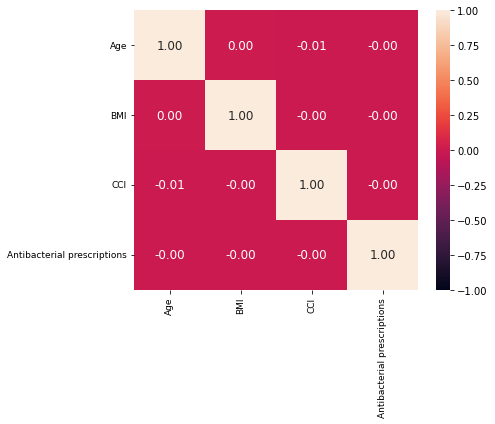

In [36]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(data_pneumonia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_pneumonia/corr_pneumonia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_pneumonia = data_pneumonia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'pneumonia_ab_date', 'ab_type_cat', 'incdt_pneumonia_date', 'date', 'period',
                       'event_pneumonia_admitted', 'duration_pneumonia_admitted'
                        ]]

In [38]:
#incident and prevalent infection 
data_pneumonia_incdt = data_pneumonia[data_pneumonia['incdt_pneumonia_date'] == 0]
data_pneumonia_prevl = data_pneumonia[data_pneumonia['incdt_pneumonia_date'] == 1]
#switch variable pneumonia_ab_date into a binary variable
data_pneumonia_incdt[['pneumonia_ab_date']] = data_pneumonia_incdt[['pneumonia_ab_date']].where(data_pneumonia_incdt[['pneumonia_ab_date']].isnull(), 1).fillna(0).astype(int)
data_pneumonia_prevl[['pneumonia_ab_date']] = data_pneumonia_prevl[['pneumonia_ab_date']].where(data_pneumonia_prevl[['pneumonia_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_pneumonia_incdt_males = data_pneumonia_incdt[data_pneumonia_incdt['sex'] == 'male']
data_pneumonia_incdt_females = data_pneumonia_incdt[data_pneumonia_incdt['sex'] == 'female']
data_pneumonia_prevl_males = data_pneumonia_prevl[data_pneumonia_prevl['sex'] == 'male']
data_pneumonia_prevl_females = data_pneumonia_prevl[data_pneumonia_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_pneumonia_incdt_15_24 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '15_24']
data_pneumonia_incdt_25_34 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '25_34']
data_pneumonia_incdt_35_44 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '35_44']
data_pneumonia_incdt_45_54 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '45_54']
data_pneumonia_incdt_55_64 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '55_64']
data_pneumonia_incdt_65_74 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '65_74']
data_pneumonia_incdt_75_more = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '75_more']
data_pneumonia_prevl_15_24 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '15_24']
data_pneumonia_prevl_25_34 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '25_34']
data_pneumonia_prevl_35_44 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '35_44']
data_pneumonia_prevl_45_54 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '45_54']
data_pneumonia_prevl_55_64 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '55_64']
data_pneumonia_prevl_65_74 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '65_74']
data_pneumonia_prevl_75_more = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_pneumonia_incdt_prepandemic = data_pneumonia_incdt[data_pneumonia_incdt['date'] <= '2019-12']
data_pneumonia_incdt_during_pandemic = data_pneumonia_incdt[(data_pneumonia_incdt['date'] >= '2020-03') & (data_pneumonia_incdt['date']<= '2021-03')]
data_pneumonia_incdt_post_2nd_lockdown = data_pneumonia_incdt[data_pneumonia_incdt['date'] <= '2021-04']
data_pneumonia_prevl_prepandemic = data_pneumonia_prevl[data_pneumonia_prevl['date'] <= '2019-12']
data_pneumonia_prevl_during_pandemic = data_pneumonia_prevl[(data_pneumonia_prevl['date'] >= '2020-03') & (data_pneumonia_prevl['date']<= '2021-03')]
data_pneumonia_prevl_post_2nd_lockdown = data_pneumonia_prevl[data_pneumonia_prevl['date'] <= '2021-04']

##separate data into sub-datasets
#no antibiotics and incident hospital admission
data_pneumonia_no_abs_incdt = data_pneumonia[data_pneumonia['pneumonia_ab_date'].isnull()]
data_pneumonia_no_abs_incdt = data_pneumonia_no_abs_incdt[data_pneumonia_no_abs_incdt['incdt_pneumonia_date'] == 0]
#with antibiotics and incident hospital admission
data_pneumonia_abs_incdt = data_pneumonia[data_pneumonia['pneumonia_ab_date'].notnull()]
data_pneumonia_abs_incdt = data_pneumonia_abs_incdt[data_pneumonia_abs_incdt['incdt_pneumonia_date'] == 0]
#no antibiotics and prevalent hospital admission
data_pneumonia_no_abs_prevl = data_pneumonia[data_pneumonia['pneumonia_ab_date'].isnull()]
data_pneumonia_no_abs_prevl = data_pneumonia_no_abs_prevl[data_pneumonia_no_abs_prevl['incdt_pneumonia_date'] == 1]
#with antibiotics and prevalent hospital admission
data_pneumonia_abs_prevl = data_pneumonia[data_pneumonia['pneumonia_ab_date'].notnull()]
data_pneumonia_abs_prevl = data_pneumonia_abs_prevl[data_pneumonia_abs_prevl['incdt_pneumonia_date'] == 1]

In [39]:
#store data for plotting hosp admission counts and percentages
%store data_pneumonia
# save data
data_pneumonia.to_csv('../output/hospitalisation_prediction_pneumonia/data_pneumonia.csv')

Stored 'data_pneumonia' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident pneumonia with no antibiotics

<lifelines.CoxPHFitter: fitted with 111124 total observations, 110321 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 111124
number of events observed = 803
   partial log-likelihood = -9309.00
         time fit was run = 2023-01-25 17:22:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.10            -0.29             0.11                 0.75                 1.11
CCI_cat[T.medium]               -0.14       0.87       0.11            -0.36             0.09                 0.70                 1.09
CCI_cat[T.high]                 -0.10       0.90       0.14            -0.37             0.16                 0.69                 1.18
CCI_cat[T.very_high]            -0.12       0.88       0.12            -0.36             0.11                 0.70                 1.12
age_cat[T.25_34]                -0.10       0.90       0.13            -0.36             0.16                 0.70                 1.17
age_cat[T.35_44]                -0.18       0.84       0.14            -0.45             0.09                 0.64                 1.09
age_cat[T.45_54]                 0.12       1.13       0.13            -0.12             0.37                 0.88                 1.45
age_cat[T.55_64]                 0.08       1.08       0.13            -0.17             0.32                 0.84                 1.38
age_cat[T.65_74]                -0.08       0.92       0.13            -0.34             0.17                 0.71                 1.19
age_cat[T.75_more]              -0.18       0.84       0.14            -0.44             0.09                 0.64                 1.09
antibacterial_brit               0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
bmi_cat[T.obese]                 0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
bmi_cat[T.overweight]            0.09       1.10       0.17            -0.23             0.42                 0.79                 1.52
bmi_cat[T.underweight]          -0.09       0.91       0.25            -0.58             0.39                 0.56                 1.48
bmi_cat[T.unknown]               0.16       1.18       0.14            -0.12             0.44                 0.89                 1.56
ethnicity[T.unknown]            -0.17       0.85       0.12            -0.39             0.06                 0.68                 1.06
ethnicity[T.white]              -0.04       0.96       0.10            -0.24             0.15                 0.79                 1.16
flu_vaccine[T.yes]              -0.08       0.92       0.12            -0.32             0.15                 0.73                 1.17
imd[T.medium]                    0.01       1.01       0.11            -0.21             0.23                 0.81                 1.26
imd[T.unaffluent]                0.05       1.05       0.11            -0.17             0.27                 0.84                 1.31
imd[T.unknown]                   0.09       1.09       0.17            -0.25             0.42                 0.78                 1.52
imd[T.very_affluent]            -0.03       0.97       0.12            -0.26             0.19                 0.77                 1.21
imd[T.very_unaffluent]          -0.08       0.92       0.12            -0.31             0.15                 0.74                 1.16
region[T.east_midlands]         -0.02       0.98       0.15            -0.32             0.28                 0.73                 1.32
region[T.london]                -0.13       0.88       

11997


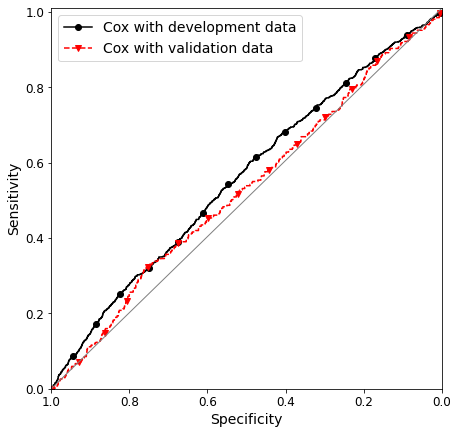

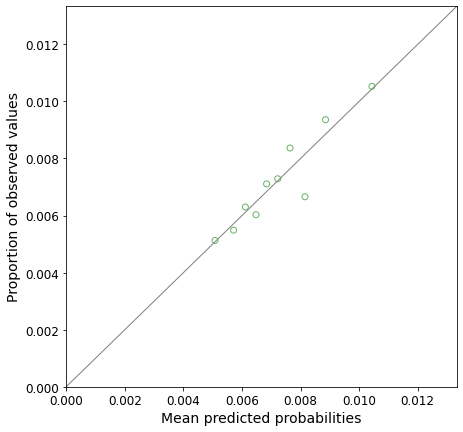

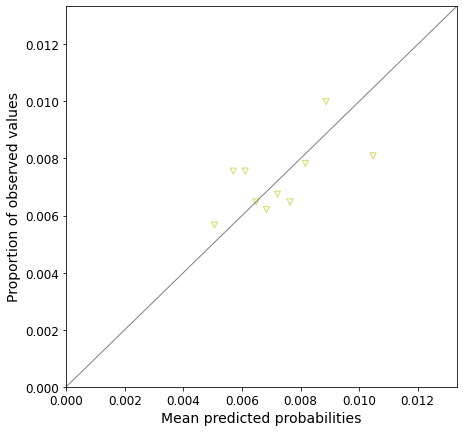

In [40]:
#data prep
data, data_pneumonia_no_abs_incdt_enc = cox_data_prep(data_pneumonia_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt)

try:
    #build cox model 
    cph_pneumonia_no_abs_incdt, data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test = cox_model_build('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_pneumonia_no_abs_incdt, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_no_abs_incdt.csv', data_pneumonia_no_abs_incdt_enc, data_pneumonia_no_abs_incdt, 'sum_betas_cph_pneumonia_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_pneumonia_no_abs_incdt, 'event_pneumonia_admitted', data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_pneumonia_no_abs_incdt, data_pneumonia_no_abs_incdt_train, 'event_pneumonia_admitted', data_pneumonia_no_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_no_abs_incdt_train.jpg', 'calibration_cph_pneumonia_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_no_abs_incdt, 'pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident pneumonia with antibiotics

<lifelines.CoxPHFitter: fitted with 12278 total observations, 12185 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 12278
number of events observed = 93
   partial log-likelihood = -858.76
         time fit was run = 2023-01-25 17:22:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.19       0.33            -0.48             0.82                 0.62                 2.27
CCI_cat[T.medium]                0.36       1.44       0.35            -0.32             1.04                 0.73                 2.84
CCI_cat[T.high]                 -0.36       0.69       0.49            -1.33             0.60                 0.26                 1.83
CCI_cat[T.very_high]             0.42       1.52       0.36            -0.28             1.12                 0.76                 3.07
age_cat[T.25_34]                -0.23       0.80       0.39            -0.99             0.53                 0.37                 1.70
age_cat[T.35_44]                -0.17       0.85       0.39            -0.93             0.60                 0.40                 1.81
age_cat[T.45_54]                 0.19       1.21       0.36            -0.50             0.89                 0.61                 2.43
age_cat[T.55_64]                -0.63       0.53       0.44            -1.49             0.23                 0.22                 1.25
age_cat[T.65_74]                 0.05       1.05       0.36            -0.66             0.75                 0.52                 2.12
age_cat[T.75_more]              -0.10       0.90       0.38            -0.84             0.64                 0.43                 1.90
antibacterial_brit              -0.06       0.94       0.08            -0.21             0.09                 0.81                 1.09
bmi_cat[T.obese]                -0.17       0.85       0.36            -0.88             0.54                 0.42                 1.72
bmi_cat[T.overweight]           -0.75       0.47       0.53            -1.78             0.29                 0.17                 1.33
bmi_cat[T.underweight]          -0.64       0.53       0.78            -2.17             0.90                 0.11                 2.45
bmi_cat[T.unknown]              -0.19       0.83       0.39            -0.95             0.57                 0.39                 1.77
ethnicity[T.unknown]             0.50       1.65       0.41            -0.31             1.31                 0.73                 3.71
ethnicity[T.white]               0.71       2.04       0.38            -0.02             1.45                 0.98                 4.27
flu_vaccine[T.yes]               0.27       1.30       0.31            -0.34             0.87                 0.71                 2.40
imd[T.medium]                    0.11       1.11       0.33            -0.55             0.76                 0.58                 2.14
imd[T.unaffluent]               -0.31       0.73       0.38            -1.05             0.43                 0.35                 1.53
imd[T.unknown]                   0.82       2.27       0.40             0.03             1.60                 1.04                 4.96
imd[T.very_affluent]             0.15       1.16       0.33            -0.50             0.80                 0.61                 2.23
imd[T.very_unaffluent]          -0.11       0.90       0.35            -0.80             0.59                 0.45                 1.81
region[T.east_midlands]          0.56       1.76       0.48            -0.37             1.50                 0.69                 4.47
region[T.london]                 0.35       1.42       0.44 

11962


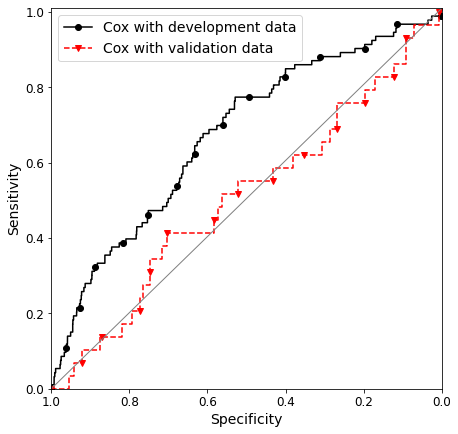

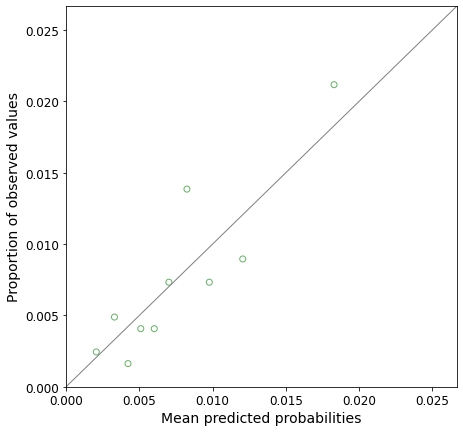

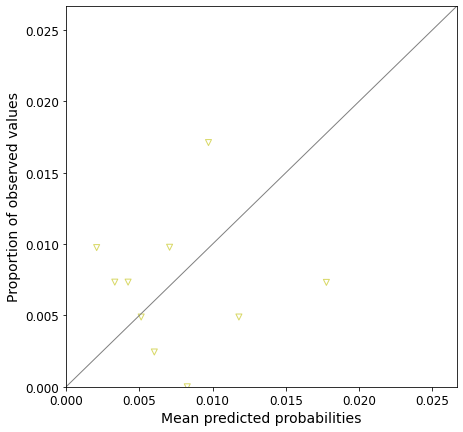

In [41]:
#data prep
data, data_pneumonia_abs_incdt_enc = cox_data_prep(data_pneumonia_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt)

try:
    #build cox model 
    cph_pneumonia_abs_incdt, data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test = cox_model_build('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_pneumonia_abs_incdt, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_abs_incdt.csv', data_pneumonia_abs_incdt_enc, data_pneumonia_abs_incdt, 'sum_betas_cph_pneumonia_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_pneumonia_abs_incdt, 'event_pneumonia_admitted', data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_pneumonia_abs_incdt, data_pneumonia_abs_incdt_train, 'event_pneumonia_admitted', data_pneumonia_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_abs_incdt_train.jpg', 'calibration_cph_pneumonia_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_abs_incdt, 'pneumonia', 'abs_incdt', data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent pneumonia with no antibiotics

<lifelines.CoxPHFitter: fitted with 12596 total observations, 12506 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 12596
number of events observed = 90
   partial log-likelihood = -822.85
         time fit was run = 2023-01-25 17:22:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.44       0.33            -0.29             1.02                 0.75                 2.78
CCI_cat[T.medium]               -0.02       0.98       0.39            -0.78             0.74                 0.46                 2.09
CCI_cat[T.high]                  0.30       1.36       0.42            -0.52             1.13                 0.60                 3.08
CCI_cat[T.very_high]             0.31       1.36       0.38            -0.44             1.06                 0.64                 2.87
age_cat[T.25_34]                 0.44       1.55       0.38            -0.31             1.19                 0.73                 3.29
age_cat[T.35_44]                 0.55       1.73       0.38            -0.20             1.30                 0.82                 3.67
age_cat[T.45_54]                 0.50       1.64       0.38            -0.25             1.24                 0.78                 3.46
age_cat[T.55_64]                -0.14       0.87       0.44            -1.00             0.72                 0.37                 2.05
age_cat[T.65_74]                -0.32       0.73       0.47            -1.23             0.60                 0.29                 1.81
age_cat[T.75_more]              -0.61       0.54       0.51            -1.60             0.39                 0.20                 1.47
antibacterial_brit              -0.04       0.96       0.08            -0.19             0.11                 0.83                 1.11
bmi_cat[T.obese]                 0.72       2.06       0.52            -0.30             1.74                 0.74                 5.71
bmi_cat[T.overweight]            1.10       2.99       0.56            -0.01             2.20                 0.99                 9.03
bmi_cat[T.underweight]          -0.31       0.73       1.12            -2.51             1.88                 0.08                 6.55
bmi_cat[T.unknown]               0.46       1.59       0.55            -0.62             1.54                 0.54                 4.67
ethnicity[T.unknown]             0.25       1.28       0.38            -0.51             1.00                 0.60                 2.72
ethnicity[T.white]               0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94
flu_vaccine[T.yes]              -0.24       0.78       0.39            -1.02             0.53                 0.36                 1.70
imd[T.medium]                    0.31       1.36       0.37            -0.41             1.03                 0.66                 2.81
imd[T.unaffluent]                0.46       1.59       0.36            -0.24             1.16                 0.79                 3.20
imd[T.unknown]                   0.16       1.17       0.57            -0.96             1.28                 0.38                 3.61
imd[T.very_affluent]             0.17       1.19       0.38            -0.57             0.92                 0.56                 2.50
imd[T.very_unaffluent]           0.54       1.72       0.35            -0.15             1.24                 0.86                 3.44
region[T.east_midlands]         -0.25       0.78       0.61            -1.44             0.94                 0.24                 2.55
region[T.london]                 0.79       2.20       0.45 

11963


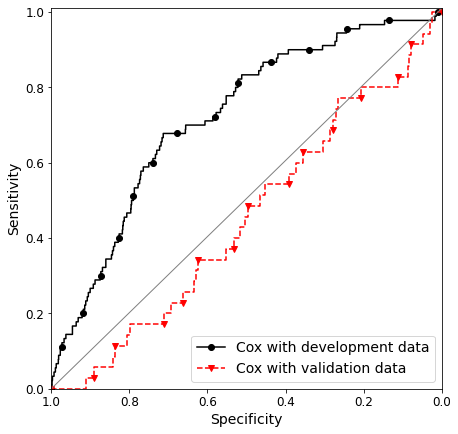

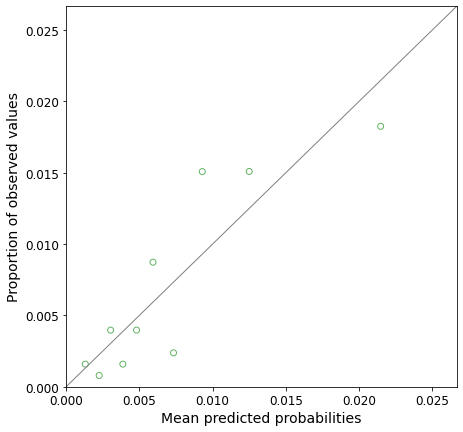

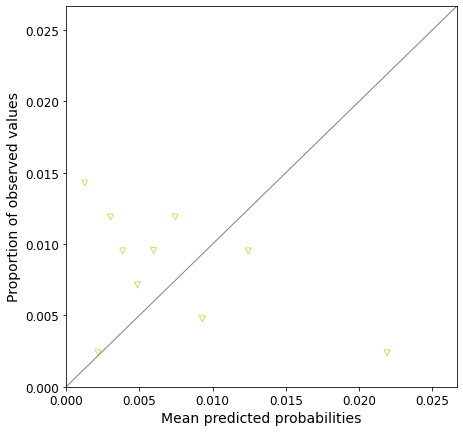

In [42]:
#data prep
data, data_pneumonia_no_abs_prevl_enc = cox_data_prep(data_pneumonia_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl)

try:
    #build cox model 
    cph_pneumonia_no_abs_prevl, data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test = cox_model_build('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_pneumonia_no_abs_prevl, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_no_abs_prevl.csv', data_pneumonia_no_abs_prevl_enc, data_pneumonia_no_abs_prevl, 'sum_betas_cph_pneumonia_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_pneumonia_no_abs_prevl, 'event_pneumonia_admitted', data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_pneumonia_no_abs_prevl, data_pneumonia_no_abs_prevl_train, 'event_pneumonia_admitted', data_pneumonia_no_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_no_abs_prevl_train.jpg', 'calibration_cph_pneumonia_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_no_abs_prevl, 'pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent pneumonia with antibiotics

<lifelines.CoxPHFitter: fitted with 1359 total observations, 1355 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1359
number of events observed = 4
   partial log-likelihood = -7.11
         time fit was run = 2023-01-25 17:22:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.52       0.22       3.62            -8.61             5.58                 0.00               264.70
CCI_cat[T.medium]                1.24       3.46       2.57            -3.79             6.27                 0.02               528.58
CCI_cat[T.high]                 -3.12       0.04       4.02           -10.99             4.75                 0.00               115.67
CCI_cat[T.very_high]             1.86       6.43       3.38            -4.77             8.49                 0.01              4872.11
age_cat[T.25_34]                -0.87       0.42       1.95            -4.70             2.95                 0.01                19.07
age_cat[T.35_44]                -5.99       0.00       6.41           -18.56             6.58                 0.00               720.79
age_cat[T.45_54]                -3.03       0.05       2.64            -8.20             2.15                 0.00                 8.57
age_cat[T.55_64]                -5.56       0.00       5.23           -15.80             4.69                 0.00               108.87
age_cat[T.65_74]                -5.76       0.00       6.92           -19.34             7.81                 0.00              2458.15
age_cat[T.75_more]              -5.31       0.00       4.88           -14.88             4.26                 0.00                71.04
antibacterial_brit               0.65       1.91       0.74            -0.80             2.10                 0.45                 8.14
bmi_cat[T.obese]                 1.81       6.11       4.37            -6.75            10.37                 0.00             31789.25
bmi_cat[T.overweight]            4.45      85.21       4.36            -4.10            12.99                 0.02             4.37e+05
bmi_cat[T.underweight]           2.97      19.54      17.20           -30.75            36.69                 0.00             8.61e+15
bmi_cat[T.unknown]               5.04     154.81       4.25            -3.30            13.38                 0.04             6.47e+05
ethnicity[T.unknown]             2.37      10.74       7.72           -12.75            17.50                 0.00             3.98e+07
ethnicity[T.white]               3.22      24.98       7.40           -11.28            17.71                 0.00             4.93e+07
flu_vaccine[T.yes]              -3.11       0.04       4.37           -11.68             5.45                 0.00               233.32
imd[T.medium]                   -5.36       0.00       5.43           -15.99             5.28                 0.00               196.30
imd[T.unaffluent]               -4.99       0.01       4.73           -14.27             4.29                 0.00                72.80
imd[T.unknown]                  -5.87       0.00      13.19           -31.73            19.98                 0.00             4.78e+08
imd[T.very_affluent]            -2.82       0.06       3.26            -9.21             3.57                 0.00                35.36
imd[T.very_unaffluent]          -1.11       0.33       2.24            -5.50             3.28                 0.00                26.58
region[T.east_midlands]         -0.13       0.88      11.08           -21.84            21.59                 0.00             2.37e+09
region[T.london]                 3.49      32.83       7.74       

12128


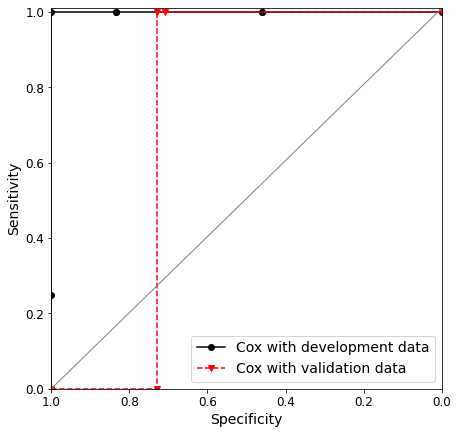

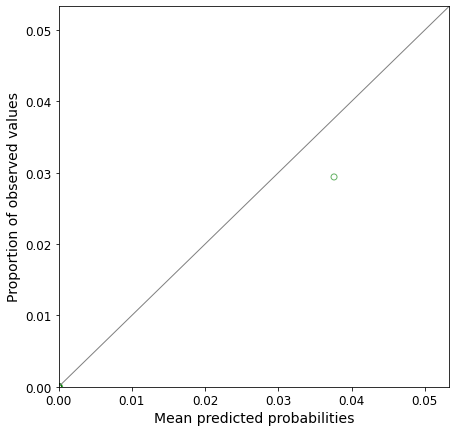

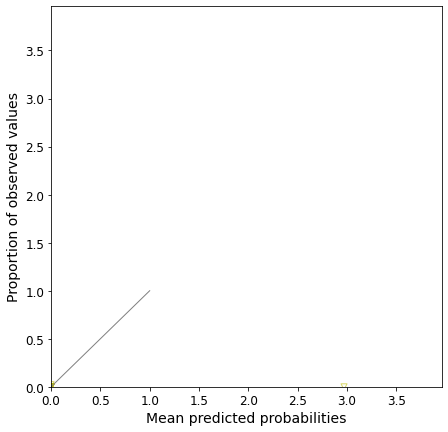

In [43]:
#data prep
data, data_pneumonia_abs_prevl_enc = cox_data_prep(data_pneumonia_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl)

try:
    #build cox model 
    cph_pneumonia_abs_prevl, data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test = cox_model_build('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_pneumonia_abs_prevl, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_abs_prevl.csv', data_pneumonia_abs_prevl_enc, data_pneumonia_abs_prevl, 'sum_betas_cph_pneumonia_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_pneumonia_abs_prevl, 'event_pneumonia_admitted', data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_pneumonia_abs_prevl, data_pneumonia_abs_prevl_train, 'event_pneumonia_admitted', data_pneumonia_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_abs_prevl_train.jpg', 'calibration_cph_pneumonia_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_abs_prevl, 'pneumonia', 'abs_prevl', data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident pneumonia

In [44]:
#data prep
data, data_pneumonia_incdt_enc = cox_data_prep(data_pneumonia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary tables from preped data
make_summary_table('pneumonia', 'incdt', data_pneumonia_incdt_enc)
make_summary_table_hosped('pneumonia', 'incdt', data_pneumonia_incdt)

try:
    cph_pneumonia_incdt, data_pneumonia_incdt_train, data_pneumonia_incdt_test = cox_model_abs_build('pneumonia', 'incdt', data_pneumonia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt, 'pneumonia', 'incdt', data_pneumonia_incdt_train, data_pneumonia_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 123402 total observations, 122499 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 123402
number of events observed = 903
   partial log-likelihood = -10565.28
         time fit was run = 2023-01-25 17:22:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.12
CCI_cat[T.medium]               -0.11       0.90       0.11            -0.32             0.10                 0.72                 1.11
CCI_cat[T.high]                 -0.16       0.85       0.13            -0.42             0.10                 0.66                 1.10
CCI_cat[T.very_high]            -0.08       0.92       0.11            -0.30             0.14                 0.74                 1.15
age_cat[T.25_34]                -0.15       0.86       0.13            -0.40             0.09                 0.67                 1.10
age_cat[T.35_44]                -0.20       0.82       0.13            -0.45             0.05                 0.64                 1.05
age_cat[T.45_54]                 0.06       1.07       0.12            -0.17             0.30                 0.84                 1.34
age_cat[T.55_64]                -0.02       0.98       0.12            -0.25             0.22                 0.78                 1.25
age_cat[T.65_74]                -0.09       0.92       0.12            -0.33             0.16                 0.72                 1.17
age_cat[T.75_more]              -0.08       0.92       0.12            -0.32             0.16                 0.73                 1.18
antibacterial_brit               0.04       1.04       0.02            -0.00             0.09                 1.00                 1.09
bmi_cat[T.obese]                 0.04       1.04       0.13            -0.21             0.29                 0.81                 1.34
bmi_cat[T.overweight]           -0.11       0.90       0.16            -0.42             0.21                 0.65                 1.23
bmi_cat[T.underweight]          -0.11       0.89       0.23            -0.57             0.34                 0.56                 1.41
bmi_cat[T.unknown]               0.10       1.11       0.14            -0.16             0.37                 0.85                 1.45
ethnicity[T.unknown]            -0.15       0.86       0.11            -0.36             0.07                 0.70                 1.07
ethnicity[T.white]              -0.02       0.98       0.09            -0.20             0.16                 0.81                 1.18
flu_vaccine[T.yes]               0.04       1.04       0.11            -0.18             0.25                 0.84                 1.29
imd[T.medium]                    0.09       1.09       0.11            -0.12             0.30                 0.89                 1.34
imd[T.unaffluent]               -0.01       0.99       0.11            -0.23             0.20                 0.80                 1.22
imd[T.unknown]                   0.18       1.20       0.16            -0.13             0.49                 0.88                 1.63
imd[T.very_affluent]            -0.00       1.00       0.11            -0.21             0.21                 0.81                 1.24
imd[T.very_unaffluent]          -0.07       0.94       0.11            -0.28             0.15                 0.75                 1.16
pneumonia_ab_date                0.02       1.02       0.11            -0.19             0.24                 0.83                 1.27
region[T.east_midlands]         -0.11       0.89      

12249


### 5-6- hospital admission related to prevalent pneumonia

In [45]:
#data prep
data, data_pneumonia_prevl_enc = cox_data_prep(data_pneumonia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary tables from preped data
make_summary_table('pneumonia', 'prevl', data_pneumonia_prevl_enc)
make_summary_table_hosped('pneumonia', 'prevl', data_pneumonia_prevl)

try:
    cph_pneumonia_prevl, data_pneumonia_prevl_train, data_pneumonia_prevl_test = cox_model_abs_build('pneumonia', 'prevl', data_pneumonia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl, 'pneumonia', 'prevl', data_pneumonia_prevl_train, data_pneumonia_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13955 total observations, 13855 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 13955
number of events observed = 100
   partial log-likelihood = -928.05
         time fit was run = 2023-01-25 17:22:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.33       0.34            -0.37             0.95                 0.69                 2.58
CCI_cat[T.medium]                0.39       1.48       0.36            -0.31             1.09                 0.73                 2.97
CCI_cat[T.high]                  0.41       1.50       0.41            -0.40             1.21                 0.67                 3.34
CCI_cat[T.very_high]             0.47       1.60       0.37            -0.25             1.20                 0.78                 3.31
age_cat[T.25_34]                 0.52       1.67       0.35            -0.17             1.20                 0.84                 3.33
age_cat[T.35_44]                 0.09       1.10       0.39            -0.66             0.85                 0.52                 2.34
age_cat[T.45_54]                 0.51       1.67       0.35            -0.17             1.20                 0.84                 3.32
age_cat[T.55_64]                -0.12       0.89       0.40            -0.91             0.66                 0.40                 1.94
age_cat[T.65_74]                -0.38       0.69       0.43            -1.23             0.48                 0.29                 1.61
age_cat[T.75_more]              -0.49       0.61       0.45            -1.37             0.39                 0.25                 1.48
antibacterial_brit              -0.06       0.95       0.07            -0.20             0.09                 0.82                 1.09
bmi_cat[T.obese]                 0.36       1.43       0.43            -0.49             1.20                 0.61                 3.32
bmi_cat[T.overweight]            0.65       1.92       0.48            -0.29             1.59                 0.75                 4.92
bmi_cat[T.underweight]          -0.07       0.93       0.82            -1.67             1.53                 0.19                 4.63
bmi_cat[T.unknown]               0.14       1.15       0.46            -0.77             1.05                 0.46                 2.85
ethnicity[T.unknown]            -0.08       0.92       0.35            -0.76             0.59                 0.47                 1.81
ethnicity[T.white]               0.17       1.18       0.30            -0.41             0.74                 0.66                 2.10
flu_vaccine[T.yes]              -0.39       0.68       0.39            -1.16             0.38                 0.31                 1.47
imd[T.medium]                   -0.03       0.97       0.35            -0.72             0.65                 0.49                 1.91
imd[T.unaffluent]               -0.03       0.97       0.35            -0.71             0.65                 0.49                 1.92
imd[T.unknown]                   0.65       1.92       0.41            -0.16             1.46                 0.85                 4.31
imd[T.very_affluent]             0.18       1.20       0.33            -0.46             0.83                 0.63                 2.30
imd[T.very_unaffluent]           0.30       1.35       0.32            -0.34             0.93                 0.71                 2.54
pneumonia_ab_date               -1.21       0.30       0.59            -2.36            -0.06                 0.09                 0.94
region[T.east_midlands]         -0.50       0.61       0.48

12230


### 5-7- hospital admission related to incident pneumonia with prescribed antibiotics categories

In [46]:
#data prep
data, data_pneumonia_incdt_abs_enc = cox_data_prep(data_pneumonia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_abs, data_pneumonia_incdt_abs_train, data_pneumonia_incdt_abs_test = cox_model_ab_type_build('pneumonia', 'incdt_ab_type', data_pneumonia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_abs, 'pneumonia', 'incdt_abs', data_pneumonia_incdt_abs_train, data_pneumonia_incdt_abs_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 123402 total observations, 122499 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 123402
number of events observed = 903
   partial log-likelihood = -10563.49
         time fit was run = 2023-01-25 17:22:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.93       0.10            -0.26             0.12                 0.77                 1.13
CCI_cat[T.medium]               -0.11       0.90       0.11            -0.32             0.10                 0.73                 1.11
CCI_cat[T.high]                 -0.16       0.85       0.13            -0.42             0.10                 0.66                 1.10
CCI_cat[T.very_high]            -0.08       0.92       0.11            -0.30             0.14                 0.74                 1.15
ab_type_cat[T.Doxycycline]     -12.71       0.00     462.23          -918.65           893.24                 0.00                  inf
ab_type_cat[T.no]                0.09       1.09       0.45            -0.79             0.97                 0.45                 2.63
ab_type_cat[T.other]             0.14       1.15       0.46            -0.76             1.04                 0.47                 2.83
age_cat[T.25_34]                -0.15       0.86       0.13            -0.40             0.09                 0.67                 1.10
age_cat[T.35_44]                -0.20       0.82       0.13            -0.45             0.05                 0.64                 1.05
age_cat[T.45_54]                 0.06       1.07       0.12            -0.17             0.30                 0.84                 1.34
age_cat[T.55_64]                -0.01       0.99       0.12            -0.25             0.22                 0.78                 1.25
age_cat[T.65_74]                -0.09       0.92       0.12            -0.33             0.16                 0.72                 1.17
age_cat[T.75_more]              -0.08       0.93       0.12            -0.32             0.17                 0.73                 1.18
antibacterial_brit               0.04       1.04       0.02            -0.00             0.09                 1.00                 1.09
bmi_cat[T.obese]                 0.04       1.05       0.13            -0.21             0.30                 0.81                 1.34
bmi_cat[T.overweight]           -0.11       0.90       0.16            -0.42             0.21                 0.66                 1.23
bmi_cat[T.underweight]          -0.11       0.89       0.23            -0.57             0.34                 0.57                 1.41
bmi_cat[T.unknown]               0.10       1.11       0.14            -0.16             0.37                 0.85                 1.45
ethnicity[T.unknown]            -0.15       0.86       0.11            -0.36             0.07                 0.70                 1.07
ethnicity[T.white]              -0.02       0.98       0.09            -0.20             0.16                 0.81                 1.18
flu_vaccine[T.yes]               0.04       1.04       0.11            -0.18             0.25                 0.84                 1.29
imd[T.medium]                    0.09       1.09       0.11            -0.12             0.30                 0.89                 1.34
imd[T.unaffluent]               -0.01       0.99       0.11            -0.23             0.20                 0.80                 1.22
imd[T.unknown]                   0.18       1.20       0.16            -0.13             0.49                 0.88                 1.63
imd[T.very_affluent]            -0.00       1.00      

12775


### 5-8- hospital admission related to prevalent pneumonia with prescribed antibiotics categories

In [47]:
#data prep
data, data_pneumonia_prevl_abs_enc = cox_data_prep(data_pneumonia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_abs, data_pneumonia_prevl_abs_train, data_pneumonia_prevl_abs_test = cox_model_ab_type_build('pneumonia', 'prevl_ab_type', data_pneumonia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_abs, 'pneumonia', 'prevl_abs', data_pneumonia_prevl_abs_train, data_pneumonia_prevl_abs_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13955 total observations, 13855 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 13955
number of events observed = 100
   partial log-likelihood = -927.82
         time fit was run = 2023-01-25 17:23:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.34            -0.37             0.95                 0.69                 2.58
CCI_cat[T.medium]                0.39       1.48       0.36            -0.31             1.09                 0.74                 2.98
CCI_cat[T.high]                  0.41       1.50       0.41            -0.40             1.21                 0.67                 3.35
CCI_cat[T.very_high]             0.47       1.61       0.37            -0.25             1.20                 0.78                 3.31
ab_type_cat[T.Doxycycline]       0.03       1.03    4168.08         -8169.26          8169.32                 0.00                  inf
ab_type_cat[T.no]               14.69   2.40e+06    2045.49         -3994.41          4023.79                 0.00                  inf
ab_type_cat[T.other]            13.56   7.74e+05    2045.49         -3995.54          4022.65                 0.00                  inf
age_cat[T.25_34]                 0.51       1.67       0.35            -0.17             1.20                 0.84                 3.33
age_cat[T.35_44]                 0.09       1.10       0.39            -0.66             0.85                 0.52                 2.34
age_cat[T.45_54]                 0.51       1.67       0.35            -0.17             1.20                 0.84                 3.32
age_cat[T.55_64]                -0.12       0.89       0.40            -0.91             0.66                 0.40                 1.94
age_cat[T.65_74]                -0.38       0.69       0.43            -1.23             0.48                 0.29                 1.61
age_cat[T.75_more]              -0.49       0.61       0.45            -1.37             0.39                 0.25                 1.48
antibacterial_brit              -0.06       0.95       0.07            -0.20             0.09                 0.82                 1.09
bmi_cat[T.obese]                 0.36       1.43       0.43            -0.49             1.20                 0.61                 3.32
bmi_cat[T.overweight]            0.66       1.93       0.48            -0.28             1.60                 0.75                 4.93
bmi_cat[T.underweight]          -0.07       0.93       0.82            -1.68             1.53                 0.19                 4.62
bmi_cat[T.unknown]               0.14       1.15       0.46            -0.77             1.05                 0.46                 2.85
ethnicity[T.unknown]            -0.08       0.92       0.35            -0.76             0.59                 0.47                 1.81
ethnicity[T.white]               0.17       1.18       0.30            -0.41             0.74                 0.66                 2.11
flu_vaccine[T.yes]              -0.39       0.68       0.39            -1.16             0.38                 0.31                 1.46
imd[T.medium]                   -0.03       0.97       0.35            -0.72             0.65                 0.49                 1.91
imd[T.unaffluent]               -0.03       0.97       0.35            -0.71             0.65                 0.49                 1.92
imd[T.unknown]                   0.65       1.92       0.41            -0.16             1.46                 0.85                 4.31
imd[T.very_affluent]             0.18       1.20       0.33

12779


### 5-9- stratified by sex
#### 5-9-1- incident males

In [48]:
#data prep
data, data_pneumonia_incdt_males_enc = cox_data_prep(data_pneumonia_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_males, data_pneumonia_incdt_males_train, data_pneumonia_incdt_males_test = cox_model_strat_sex_build('pneumonia', 'incdt_males', data_pneumonia_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_males, 'pneumonia', 'incdt_males', data_pneumonia_incdt_males_train, data_pneumonia_incdt_males_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 60552 total observations, 60105 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 60552
number of events observed = 447
   partial log-likelihood = -4897.96
         time fit was run = 2023-01-25 17:23:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.14            -0.29             0.25                 0.75                 1.28
CCI_cat[T.medium]               -0.09       0.92       0.15            -0.39             0.21                 0.68                 1.24
CCI_cat[T.high]                  0.04       1.04       0.18            -0.30             0.39                 0.74                 1.48
CCI_cat[T.very_high]            -0.33       0.72       0.17            -0.67             0.01                 0.51                 1.01
age_cat[T.25_34]                 0.22       1.24       0.19            -0.15             0.58                 0.86                 1.79
age_cat[T.35_44]                 0.11       1.11       0.19            -0.27             0.49                 0.76                 1.63
age_cat[T.45_54]                 0.46       1.58       0.18             0.11             0.81                 1.12                 2.24
age_cat[T.55_64]                 0.21       1.23       0.19            -0.16             0.57                 0.85                 1.77
age_cat[T.65_74]                 0.43       1.53       0.18             0.07             0.78                 1.08                 2.17
age_cat[T.75_more]               0.04       1.04       0.20            -0.35             0.42                 0.71                 1.53
antibacterial_brit               0.02       1.02       0.03            -0.04             0.08                 0.96                 1.09
bmi_cat[T.obese]                -0.13       0.88       0.18            -0.47             0.22                 0.62                 1.24
bmi_cat[T.overweight]           -0.18       0.84       0.22            -0.61             0.26                 0.54                 1.30
bmi_cat[T.underweight]          -0.33       0.72       0.34            -1.00             0.34                 0.37                 1.41
bmi_cat[T.unknown]               0.09       1.09       0.18            -0.27             0.45                 0.76                 1.57
ethnicity[T.unknown]            -0.02       0.98       0.16            -0.32             0.29                 0.72                 1.33
ethnicity[T.white]               0.01       1.01       0.14            -0.26             0.28                 0.77                 1.32
flu_vaccine[T.yes]              -0.25       0.78       0.17            -0.59             0.10                 0.56                 1.10
imd[T.medium]                   -0.06       0.95       0.15            -0.35             0.24                 0.70                 1.27
imd[T.unaffluent]               -0.11       0.90       0.15            -0.41             0.19                 0.66                 1.21
imd[T.unknown]                  -0.20       0.82       0.25            -0.70             0.29                 0.50                 1.34
imd[T.very_affluent]            -0.03       0.97       0.15            -0.32             0.27                 0.73                 1.31
imd[T.very_unaffluent]          -0.11       0.90       0.15            -0.41             0.19                 0.66                 1.21
pneumonia_ab_date                0.06       1.06       0.15            -0.24             0.36                 0.79                 1.43
region[T.east_midlands]         -0.12       0.89       0.2

11990


#### 5-9-2- incident females

In [49]:
#data prep
data, data_pneumonia_incdt_females_enc = cox_data_prep(data_pneumonia_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_females, data_pneumonia_incdt_females_train, data_pneumonia_incdt_females_test = cox_model_strat_sex_build('pneumonia', 'incdt_females', data_pneumonia_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_females, 'pneumonia', 'incdt_females', data_pneumonia_incdt_females_train, data_pneumonia_incdt_females_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 62850 total observations, 62399 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 62850
number of events observed = 451
   partial log-likelihood = -4957.76
         time fit was run = 2023-01-25 17:23:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.33       0.72       0.13            -0.59            -0.07                 0.55                 0.93
CCI_cat[T.medium]               -0.21       0.81       0.15            -0.49             0.08                 0.61                 1.08
CCI_cat[T.high]                 -0.37       0.69       0.19            -0.74            -0.00                 0.48                 1.00
CCI_cat[T.very_high]            -0.22       0.80       0.15            -0.52             0.08                 0.60                 1.09
age_cat[T.25_34]                -0.40       0.67       0.18            -0.74            -0.05                 0.48                 0.95
age_cat[T.35_44]                -0.26       0.77       0.17            -0.59             0.07                 0.55                 1.07
age_cat[T.45_54]                -0.16       0.85       0.16            -0.49             0.16                 0.61                 1.17
age_cat[T.55_64]                -0.08       0.92       0.16            -0.40             0.23                 0.67                 1.26
age_cat[T.65_74]                -0.45       0.64       0.18            -0.80            -0.10                 0.45                 0.90
age_cat[T.75_more]              -0.31       0.74       0.17            -0.64             0.03                 0.53                 1.03
antibacterial_brit               0.02       1.02       0.03            -0.04             0.08                 0.96                 1.09
bmi_cat[T.obese]                -0.18       0.83       0.17            -0.51             0.14                 0.60                 1.16
bmi_cat[T.overweight]           -0.19       0.83       0.21            -0.60             0.22                 0.55                 1.25
bmi_cat[T.underweight]          -0.07       0.93       0.29            -0.64             0.50                 0.53                 1.66
bmi_cat[T.unknown]              -0.12       0.88       0.18            -0.47             0.23                 0.62                 1.26
ethnicity[T.unknown]            -0.10       0.91       0.16            -0.41             0.21                 0.66                 1.24
ethnicity[T.white]               0.07       1.07       0.14            -0.20             0.33                 0.82                 1.40
flu_vaccine[T.yes]              -0.07       0.93       0.16            -0.39             0.25                 0.68                 1.28
imd[T.medium]                    0.31       1.36       0.15             0.00             0.61                 1.00                 1.84
imd[T.unaffluent]                0.25       1.29       0.16            -0.05             0.56                 0.95                 1.75
imd[T.unknown]                   0.45       1.57       0.22             0.02             0.87                 1.02                 2.40
imd[T.very_affluent]             0.09       1.10       0.16            -0.23             0.42                 0.80                 1.52
imd[T.very_unaffluent]           0.08       1.09       0.16            -0.24             0.40                 0.79                 1.50
pneumonia_ab_date               -0.03       0.97       0.16            -0.35             0.28                 0.71                 1.32
region[T.east_midlands]          0.26       1.30       0.2

11989


#### 5-9-3- prevalent males

In [50]:
#data prep
data, data_pneumonia_prevl_males_enc = cox_data_prep(data_pneumonia_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_males, data_pneumonia_prevl_males_train, data_pneumonia_prevl_males_test = cox_model_strat_sex_build('pneumonia', 'prevl_males', data_pneumonia_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_males, 'pneumonia', 'prevl_males', data_pneumonia_prevl_males_train, data_pneumonia_prevl_males_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6813 total observations, 6769 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 6813
number of events observed = 44
   partial log-likelihood = -368.13
         time fit was run = 2023-01-25 17:23:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.45       0.48            -0.56             1.31                 0.57                 3.69
CCI_cat[T.medium]                0.10       1.11       0.54            -0.96             1.16                 0.38                 3.20
CCI_cat[T.high]                  0.26       1.29       0.61            -0.93             1.45                 0.39                 4.26
CCI_cat[T.very_high]             0.34       1.41       0.54            -0.72             1.41                 0.49                 4.09
age_cat[T.25_34]                 0.63       1.88       0.52            -0.39             1.65                 0.68                 5.19
age_cat[T.35_44]                 0.25       1.28       0.56            -0.85             1.34                 0.43                 3.83
age_cat[T.45_54]                 0.26       1.30       0.56            -0.83             1.36                 0.43                 3.89
age_cat[T.55_64]                -0.35       0.70       0.65            -1.62             0.92                 0.20                 2.51
age_cat[T.65_74]                 0.14       1.15       0.58            -0.99             1.28                 0.37                 3.60
age_cat[T.75_more]              -0.33       0.72       0.65            -1.60             0.94                 0.20                 2.56
antibacterial_brit              -0.04       0.96       0.11            -0.25             0.17                 0.78                 1.18
bmi_cat[T.obese]                 0.33       1.40       0.61            -0.86             1.53                 0.42                 4.63
bmi_cat[T.overweight]            0.66       1.94       0.68            -0.67             1.99                 0.51                 7.34
bmi_cat[T.underweight]          -0.18       0.83       1.16            -2.45             2.09                 0.09                 8.09
bmi_cat[T.unknown]              -0.59       0.55       0.73            -2.03             0.84                 0.13                 2.32
ethnicity[T.unknown]            -0.37       0.69       0.52            -1.39             0.64                 0.25                 1.91
ethnicity[T.white]               0.09       1.09       0.42            -0.74             0.92                 0.48                 2.50
flu_vaccine[T.yes]               0.61       1.84       0.42            -0.21             1.42                 0.81                 4.14
imd[T.medium]                    0.00       1.00       0.47            -0.93             0.93                 0.40                 2.54
imd[T.unaffluent]                0.26       1.30       0.45            -0.63             1.15                 0.53                 3.15
imd[T.unknown]                   0.64       1.90       0.61            -0.55             1.83                 0.58                 6.22
imd[T.very_affluent]            -0.19       0.82       0.51            -1.19             0.80                 0.31                 2.23
imd[T.very_unaffluent]          -0.81       0.45       0.60            -1.99             0.38                 0.14                 1.46
pneumonia_ab_date               -0.47       0.63       0.60            -1.65             0.71                 0.19                 2.04
region[T.east_midlands]          0.29       1.34       0.77    

11971


#### 5-9-4- prevalent females

In [51]:
try:
    #data prep
    data, data_pneumonia_prevl_females_enc = cox_data_prep(data_pneumonia_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

    #cox model
    cph_pneumonia_prevl_females, data_pneumonia_prevl_females_train, data_pneumonia_prevl_females_test = cox_model_strat_sex_build('pneumonia', 'prevl_females', data_pneumonia_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_females, 'pneumonia', 'prevl_females', data_pneumonia_prevl_females_train, data_pneumonia_prevl_females_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7141 total observations, 7090 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 7141
number of events observed = 51
   partial log-likelihood = -420.82
         time fit was run = 2023-01-25 17:23:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.40            -0.73             0.85                 0.48                 2.35
CCI_cat[T.medium]               -0.03       0.97       0.45            -0.91             0.86                 0.40                 2.35
CCI_cat[T.high]                 -0.79       0.46       0.67            -2.10             0.53                 0.12                 1.69
CCI_cat[T.very_high]            -0.13       0.88       0.49            -1.09             0.83                 0.34                 2.28
age_cat[T.25_34]                 0.08       1.09       0.49            -0.87             1.04                 0.42                 2.82
age_cat[T.35_44]                 0.21       1.24       0.48            -0.72             1.15                 0.49                 3.15
age_cat[T.45_54]                 0.52       1.68       0.45            -0.37             1.40                 0.69                 4.07
age_cat[T.55_64]                -0.35       0.71       0.54            -1.41             0.72                 0.24                 2.05
age_cat[T.65_74]                -2.10       0.12       1.06            -4.18            -0.01                 0.02                 0.99
age_cat[T.75_more]              -0.67       0.51       0.61            -1.88             0.53                 0.15                 1.70
antibacterial_brit               0.10       1.11       0.10            -0.09             0.29                 0.92                 1.33
bmi_cat[T.obese]                 1.23       3.42       1.02            -0.77             3.23                 0.46                25.35
bmi_cat[T.overweight]            1.66       5.24       1.06            -0.43             3.74                 0.65                42.02
bmi_cat[T.underweight]           1.35       3.86       1.23            -1.06             3.76                 0.35                43.07
bmi_cat[T.unknown]               1.48       4.37       1.03            -0.55             3.50                 0.58                33.21
ethnicity[T.unknown]             0.47       1.59       0.53            -0.57             1.50                 0.56                 4.49
ethnicity[T.white]               0.52       1.69       0.48            -0.42             1.47                 0.65                 4.34
flu_vaccine[T.yes]              -1.73       0.18       1.01            -3.71             0.25                 0.02                 1.29
imd[T.medium]                    0.24       1.27       0.61            -0.95             1.43                 0.39                 4.18
imd[T.unaffluent]                0.38       1.47       0.59            -0.76             1.53                 0.47                 4.64
imd[T.unknown]                   1.14       3.14       0.67            -0.18             2.46                 0.84                11.76
imd[T.very_affluent]             0.99       2.68       0.53            -0.05             2.02                 0.95                 7.54
imd[T.very_unaffluent]           1.18       3.26       0.51             0.17             2.19                 1.19                 8.91
pneumonia_ab_date               -1.59       0.20       1.01            -3.57             0.40                 0.03                 1.49
region[T.east_midlands]         -0.49       0.62       0.57    

11984


### 5-10- stratified by age category
#### 5-10-1- incident

In [52]:
#data prep
data, data_pneumonia_incdt_15_24_enc = cox_data_prep(data_pneumonia_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_15_24, data_pneumonia_incdt_15_24_train, data_pneumonia_incdt_15_24_test = cox_model_strat_age_build('pneumonia', 'incdt_15_24', data_pneumonia_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_15_24, 'pneumonia', 'incdt_15_24', data_pneumonia_incdt_15_24_train, data_pneumonia_incdt_15_24_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17699 total observations, 17567 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17699
number of events observed = 132
   partial log-likelihood = -1274.49
         time fit was run = 2023-01-25 17:23:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.00       1.00       0.27            -0.54             0.53                 0.58                 1.70
CCI_cat[T.medium]                0.17       1.19       0.29            -0.40             0.74                 0.67                 2.09
CCI_cat[T.high]                  0.12       1.13       0.35            -0.56             0.81                 0.57                 2.24
CCI_cat[T.very_high]             0.24       1.27       0.30            -0.34             0.83                 0.71                 2.28
antibacterial_brit              -0.01       0.99       0.06            -0.13             0.11                 0.87                 1.11
bmi_cat[T.obese]                -0.53       0.59       0.29            -1.10             0.04                 0.33                 1.04
bmi_cat[T.overweight]           -0.34       0.71       0.37            -1.07             0.39                 0.34                 1.48
bmi_cat[T.underweight]          -0.04       0.96       0.48            -0.99             0.91                 0.37                 2.50
bmi_cat[T.unknown]              -0.22       0.80       0.30            -0.82             0.37                 0.44                 1.45
ethnicity[T.unknown]            -0.19       0.82       0.27            -0.73             0.34                 0.48                 1.41
ethnicity[T.white]              -0.22       0.80       0.24            -0.69             0.24                 0.50                 1.27
flu_vaccine[T.yes]              -0.22       0.80       0.32            -0.84             0.39                 0.43                 1.48
imd[T.medium]                   -0.11       0.90       0.29            -0.67             0.46                 0.51                 1.59
imd[T.unaffluent]                0.22       1.25       0.26            -0.30             0.74                 0.74                 2.09
imd[T.unknown]                   0.54       1.71       0.36            -0.17             1.24                 0.84                 3.46
imd[T.very_affluent]            -0.51       0.60       0.32            -1.15             0.13                 0.32                 1.13
imd[T.very_unaffluent]          -0.00       1.00       0.28            -0.55             0.54                 0.58                 1.72
pneumonia_ab_date                0.07       1.07       0.28            -0.48             0.63                 0.62                 1.87
region[T.east_midlands]          0.20       1.22       0.36            -0.51             0.91                 0.60                 2.48
region[T.london]                -0.30       0.74       0.35            -0.97             0.38                 0.38                 1.47
region[T.north_east]            -0.16       0.85       0.39            -0.94             0.61                 0.39                 1.84
region[T.north_west]            -0.03       0.98       0.38            -0.77             0.72                 0.46                 2.05
region[T.south_east]             0.11       1.12       0.37            -0.61             0.83                 0.55                 2.30
region[T.south_west]            -0.06       0.94       0.38            -0.80             0.68                 0.45                 1.97
region[T.west_midlands]          0.01       1.01       0.3

10719


In [53]:
#data prep
data, data_pneumonia_incdt_25_34_enc = cox_data_prep(data_pneumonia_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_25_34, data_pneumonia_incdt_25_34_train, data_pneumonia_incdt_25_34_test = cox_model_strat_age_build('pneumonia', 'incdt_25_34', data_pneumonia_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_25_34, 'pneumonia', 'incdt_25_34', data_pneumonia_incdt_25_34_train, data_pneumonia_incdt_25_34_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17905 total observations, 17770 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17905
number of events observed = 135
   partial log-likelihood = -1310.88
         time fit was run = 2023-01-25 17:23:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.81       0.24            -0.68             0.27                 0.50                 1.32
CCI_cat[T.medium]               -0.13       0.88       0.27            -0.66             0.40                 0.52                 1.49
CCI_cat[T.high]                  0.12       1.12       0.30            -0.46             0.69                 0.63                 2.00
CCI_cat[T.very_high]            -0.52       0.59       0.32            -1.14             0.10                 0.32                 1.10
antibacterial_brit               0.03       1.03       0.06            -0.09             0.15                 0.91                 1.16
bmi_cat[T.obese]                -0.04       0.96       0.33            -0.68             0.60                 0.51                 1.81
bmi_cat[T.overweight]           -0.03       0.97       0.40            -0.81             0.75                 0.45                 2.12
bmi_cat[T.underweight]           0.11       1.12       0.54            -0.94             1.17                 0.39                 3.23
bmi_cat[T.unknown]               0.12       1.12       0.34            -0.56             0.79                 0.57                 2.20
ethnicity[T.unknown]             0.08       1.08       0.29            -0.48             0.64                 0.62                 1.89
ethnicity[T.white]               0.04       1.04       0.26            -0.46             0.54                 0.63                 1.71
flu_vaccine[T.yes]              -0.20       0.82       0.32            -0.81             0.42                 0.44                 1.52
imd[T.medium]                    0.30       1.35       0.29            -0.27             0.87                 0.76                 2.40
imd[T.unaffluent]                0.18       1.20       0.30            -0.40             0.77                 0.67                 2.16
imd[T.unknown]                   0.46       1.58       0.40            -0.32             1.24                 0.72                 3.45
imd[T.very_affluent]             0.22       1.24       0.29            -0.36             0.79                 0.70                 2.21
imd[T.very_unaffluent]           0.32       1.38       0.29            -0.24             0.89                 0.78                 2.44
pneumonia_ab_date                0.01       1.01       0.28            -0.54             0.57                 0.58                 1.76
region[T.east_midlands]         -0.10       0.90       0.42            -0.92             0.71                 0.40                 2.04
region[T.london]                 0.19       1.21       0.34            -0.48             0.86                 0.62                 2.36
region[T.north_east]             0.32       1.37       0.37            -0.41             1.05                 0.66                 2.85
region[T.north_west]            -0.46       0.63       0.46            -1.36             0.43                 0.26                 1.54
region[T.south_east]            -0.12       0.88       0.41            -0.92             0.68                 0.40                 1.97
region[T.south_west]             0.18       1.20       0.38            -0.57             0.93                 0.57                 2.53
region[T.west_midlands]          0.28       1.32       0.3

10700


In [54]:
#data prep
data, data_pneumonia_incdt_35_44_enc = cox_data_prep(data_pneumonia_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_35_44, data_pneumonia_incdt_35_44_train, data_pneumonia_incdt_35_44_test = cox_model_strat_age_build('pneumonia', 'incdt_35_44', data_pneumonia_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_35_44, 'pneumonia', 'incdt_35_44', data_pneumonia_incdt_35_44_train, data_pneumonia_incdt_35_44_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17373 total observations, 17261 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17373
number of events observed = 112
   partial log-likelihood = -1073.24
         time fit was run = 2023-01-25 17:23:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.28       0.75       0.27            -0.81             0.25                 0.44                 1.28
CCI_cat[T.medium]               -0.15       0.86       0.30            -0.73             0.43                 0.48                 1.54
CCI_cat[T.high]                  0.01       1.01       0.34            -0.66             0.68                 0.51                 1.97
CCI_cat[T.very_high]            -0.42       0.66       0.34            -1.07             0.24                 0.34                 1.27
antibacterial_brit              -0.03       0.97       0.07            -0.16             0.10                 0.85                 1.11
bmi_cat[T.obese]                -0.09       0.91       0.34            -0.76             0.58                 0.47                 1.79
bmi_cat[T.overweight]            0.11       1.12       0.41            -0.69             0.92                 0.50                 2.50
bmi_cat[T.underweight]          -0.75       0.47       0.78            -2.27             0.77                 0.10                 2.16
bmi_cat[T.unknown]              -0.20       0.82       0.38            -0.93             0.54                 0.39                 1.71
ethnicity[T.unknown]            -0.33       0.72       0.31            -0.94             0.28                 0.39                 1.32
ethnicity[T.white]              -0.08       0.92       0.26            -0.59             0.43                 0.55                 1.53
flu_vaccine[T.yes]              -0.52       0.59       0.39            -1.29             0.24                 0.28                 1.27
imd[T.medium]                   -0.38       0.69       0.36            -1.08             0.33                 0.34                 1.39
imd[T.unaffluent]               -0.03       0.97       0.33            -0.68             0.61                 0.51                 1.85
imd[T.unknown]                   0.00       1.00       0.50            -0.98             0.99                 0.37                 2.69
imd[T.very_affluent]             0.34       1.40       0.30            -0.26             0.93                 0.77                 2.53
imd[T.very_unaffluent]           0.52       1.68       0.29            -0.06             1.09                 0.95                 2.97
pneumonia_ab_date               -0.01       0.99       0.32            -0.63             0.61                 0.53                 1.85
region[T.east_midlands]          1.12       3.07       0.52             0.11             2.14                 1.12                 8.47
region[T.london]                 0.66       1.93       0.50            -0.33             1.64                 0.72                 5.18
region[T.north_east]             0.45       1.57       0.57            -0.66             1.57                 0.51                 4.82
region[T.north_west]             0.85       2.34       0.53            -0.20             1.89                 0.82                 6.64
region[T.south_east]             1.23       3.42       0.51             0.22             2.24                 1.25                 9.35
region[T.south_west]             0.51       1.67       0.57            -0.61             1.63                 0.55                 5.10
region[T.west_midlands]          0.67       1.94       0.5

10709


In [55]:
#data prep
data, data_pneumonia_incdt_45_54_enc = cox_data_prep(data_pneumonia_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_45_54, data_pneumonia_incdt_45_54_train, data_pneumonia_incdt_45_54_test = cox_model_strat_age_build('pneumonia', 'incdt_45_54', data_pneumonia_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_45_54, 'pneumonia', 'incdt_45_54', data_pneumonia_incdt_45_54_train, data_pneumonia_incdt_45_54_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17766 total observations, 17625 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17766
number of events observed = 141
   partial log-likelihood = -1362.28
         time fit was run = 2023-01-25 17:23:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.26       0.77       0.22            -0.69             0.18                 0.50                 1.20
CCI_cat[T.medium]               -0.78       0.46       0.29            -1.34            -0.22                 0.26                 0.80
CCI_cat[T.high]                 -0.93       0.39       0.38            -1.67            -0.19                 0.19                 0.83
CCI_cat[T.very_high]            -0.29       0.75       0.27            -0.82             0.23                 0.44                 1.26
antibacterial_brit              -0.02       0.98       0.06            -0.14             0.10                 0.87                 1.10
bmi_cat[T.obese]                 0.16       1.17       0.34            -0.50             0.82                 0.60                 2.27
bmi_cat[T.overweight]           -0.02       0.98       0.42            -0.85             0.81                 0.43                 2.24
bmi_cat[T.underweight]           0.49       1.63       0.49            -0.48             1.45                 0.62                 4.28
bmi_cat[T.unknown]               0.09       1.09       0.36            -0.62             0.79                 0.54                 2.21
ethnicity[T.unknown]            -0.19       0.83       0.28            -0.74             0.36                 0.48                 1.43
ethnicity[T.white]              -0.00       1.00       0.24            -0.47             0.47                 0.63                 1.59
flu_vaccine[T.yes]              -0.27       0.76       0.31            -0.89             0.34                 0.41                 1.41
imd[T.medium]                   -0.45       0.64       0.28            -0.99             0.09                 0.37                 1.10
imd[T.unaffluent]               -0.43       0.65       0.28            -0.97             0.11                 0.38                 1.11
imd[T.unknown]                   0.16       1.18       0.36            -0.55             0.87                 0.58                 2.39
imd[T.very_affluent]            -0.14       0.87       0.25            -0.63             0.36                 0.53                 1.43
imd[T.very_unaffluent]          -0.37       0.69       0.27            -0.90             0.15                 0.41                 1.17
pneumonia_ab_date                0.08       1.08       0.28            -0.48             0.63                 0.62                 1.88
region[T.east_midlands]         -0.05       0.95       0.35            -0.74             0.64                 0.47                 1.90
region[T.london]                -0.13       0.88       0.31            -0.74             0.49                 0.48                 1.63
region[T.north_east]            -0.45       0.64       0.40            -1.24             0.34                 0.29                 1.41
region[T.north_west]             0.16       1.17       0.34            -0.52             0.83                 0.60                 2.30
region[T.south_east]            -0.21       0.81       0.37            -0.94             0.52                 0.39                 1.69
region[T.south_west]            -0.03       0.97       0.35            -0.73             0.66                 0.48                 1.93
region[T.west_midlands]         -0.45       0.64       0.4

10724


In [56]:
#data prep
data, data_pneumonia_incdt_55_64_enc = cox_data_prep(data_pneumonia_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_55_64, data_pneumonia_incdt_55_64_train, data_pneumonia_incdt_55_64_test = cox_model_strat_age_build('pneumonia', 'incdt_55_64', data_pneumonia_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_55_64, 'pneumonia', 'incdt_55_64', data_pneumonia_incdt_55_64_train, data_pneumonia_incdt_55_64_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17721 total observations, 17591 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17721
number of events observed = 130
   partial log-likelihood = -1257.68
         time fit was run = 2023-01-25 17:23:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.37       0.69       0.23            -0.82             0.09                 0.44                 1.10
CCI_cat[T.medium]               -0.37       0.69       0.26            -0.89             0.15                 0.41                 1.16
CCI_cat[T.high]                 -0.68       0.50       0.38            -1.42             0.06                 0.24                 1.06
CCI_cat[T.very_high]            -0.38       0.68       0.29            -0.94             0.18                 0.39                 1.20
antibacterial_brit               0.04       1.05       0.06            -0.07             0.16                 0.93                 1.18
bmi_cat[T.obese]                 0.01       1.01       0.32            -0.63             0.64                 0.53                 1.90
bmi_cat[T.overweight]           -0.61       0.54       0.45            -1.50             0.27                 0.22                 1.31
bmi_cat[T.underweight]          -0.14       0.87       0.58            -1.29             1.01                 0.28                 2.73
bmi_cat[T.unknown]              -0.20       0.82       0.35            -0.89             0.49                 0.41                 1.64
ethnicity[T.unknown]             0.21       1.23       0.31            -0.39             0.80                 0.67                 2.23
ethnicity[T.white]               0.24       1.27       0.27            -0.30             0.78                 0.74                 2.18
flu_vaccine[T.yes]               0.07       1.08       0.28            -0.48             0.63                 0.62                 1.88
imd[T.medium]                    0.36       1.43       0.28            -0.20             0.92                 0.82                 2.50
imd[T.unaffluent]                0.11       1.12       0.30            -0.48             0.70                 0.62                 2.01
imd[T.unknown]                  -0.61       0.54       0.62            -1.82             0.60                 0.16                 1.82
imd[T.very_affluent]             0.43       1.53       0.28            -0.13             0.98                 0.88                 2.66
imd[T.very_unaffluent]          -0.03       0.97       0.31            -0.64             0.57                 0.53                 1.77
pneumonia_ab_date               -0.64       0.53       0.39            -1.40             0.12                 0.25                 1.13
region[T.east_midlands]          0.17       1.19       0.37            -0.55             0.89                 0.58                 2.44
region[T.london]                -0.24       0.78       0.34            -0.91             0.42                 0.40                 1.53
region[T.north_east]            -0.42       0.66       0.44            -1.29             0.45                 0.28                 1.57
region[T.north_west]             0.02       1.02       0.38            -0.72             0.76                 0.49                 2.14
region[T.south_east]            -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.87
region[T.south_west]             0.07       1.08       0.37            -0.65             0.79                 0.52                 2.21
region[T.west_midlands]          0.08       1.08       0.3

10710


In [57]:
#data prep
data, data_pneumonia_incdt_65_74_enc = cox_data_prep(data_pneumonia_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_65_74, data_pneumonia_incdt_65_74_train, data_pneumonia_incdt_65_74_test = cox_model_strat_age_build('pneumonia', 'incdt_65_74', data_pneumonia_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_65_74, 'pneumonia', 'incdt_65_74', data_pneumonia_incdt_65_74_train, data_pneumonia_incdt_65_74_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17729 total observations, 17604 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17729
number of events observed = 125
   partial log-likelihood = -1207.25
         time fit was run = 2023-01-25 17:23:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.45       0.29            -0.19             0.94                 0.82                 2.55
CCI_cat[T.medium]                0.31       1.36       0.32            -0.31             0.93                 0.73                 2.54
CCI_cat[T.high]                  0.38       1.47       0.36            -0.32             1.09                 0.72                 2.97
CCI_cat[T.very_high]             0.11       1.12       0.34            -0.56             0.79                 0.57                 2.20
antibacterial_brit               0.02       1.02       0.06            -0.11             0.14                 0.90                 1.15
bmi_cat[T.obese]                -0.13       0.88       0.34            -0.81             0.54                 0.45                 1.72
bmi_cat[T.overweight]            0.30       1.34       0.40            -0.48             1.07                 0.62                 2.92
bmi_cat[T.underweight]           0.09       1.09       0.59            -1.07             1.25                 0.34                 3.49
bmi_cat[T.unknown]               0.21       1.24       0.36            -0.48             0.91                 0.62                 2.49
ethnicity[T.unknown]            -0.42       0.66       0.30            -1.01             0.16                 0.37                 1.18
ethnicity[T.white]              -0.06       0.94       0.24            -0.53             0.41                 0.59                 1.51
flu_vaccine[T.yes]               0.05       1.05       0.29            -0.53             0.62                 0.59                 1.86
imd[T.medium]                   -0.04       0.97       0.28            -0.59             0.51                 0.56                 1.67
imd[T.unaffluent]               -0.02       0.98       0.28            -0.58             0.53                 0.56                 1.70
imd[T.unknown]                   0.27       1.31       0.39            -0.49             1.04                 0.61                 2.82
imd[T.very_affluent]            -0.01       0.99       0.28            -0.56             0.53                 0.57                 1.70
imd[T.very_unaffluent]          -0.65       0.52       0.34            -1.33             0.02                 0.27                 1.02
pneumonia_ab_date                0.39       1.48       0.26            -0.11             0.89                 0.90                 2.44
region[T.east_midlands]         -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.86
region[T.london]                -0.39       0.67       0.35            -1.08             0.30                 0.34                 1.35
region[T.north_east]            -0.19       0.83       0.39            -0.96             0.58                 0.38                 1.79
region[T.north_west]            -0.10       0.91       0.39            -0.85             0.66                 0.43                 1.93
region[T.south_east]             0.23       1.26       0.36            -0.47             0.93                 0.63                 2.54
region[T.south_west]            -0.28       0.75       0.40            -1.07             0.51                 0.34                 1.66
region[T.west_midlands]          0.09       1.09       0.3

10708


In [58]:
#data prep
data, data_pneumonia_incdt_75_more_enc = cox_data_prep(data_pneumonia_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_75_more, data_pneumonia_incdt_75_more_train, data_pneumonia_incdt_75_more_test = cox_model_strat_age_build('pneumonia', 'incdt_75_more', data_pneumonia_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_75_more, 'pneumonia', 'incdt_75_more', data_pneumonia_incdt_75_more_train, data_pneumonia_incdt_75_more_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17208 total observations, 17092 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17208
number of events observed = 116
   partial log-likelihood = -1115.38
         time fit was run = 2023-01-25 17:23:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.25       1.28       0.28            -0.29             0.79                 0.75                 2.21
CCI_cat[T.medium]                0.16       1.18       0.31            -0.44             0.77                 0.64                 2.16
CCI_cat[T.high]                 -0.43       0.65       0.45            -1.30             0.44                 0.27                 1.56
CCI_cat[T.very_high]             0.07       1.07       0.33            -0.58             0.71                 0.56                 2.04
antibacterial_brit               0.08       1.08       0.06            -0.05             0.20                 0.95                 1.22
bmi_cat[T.obese]                -0.13       0.87       0.34            -0.80             0.54                 0.45                 1.71
bmi_cat[T.overweight]           -0.71       0.49       0.49            -1.68             0.26                 0.19                 1.29
bmi_cat[T.underweight]          -0.68       0.51       0.78            -2.20             0.84                 0.11                 2.31
bmi_cat[T.unknown]               0.14       1.15       0.36            -0.56             0.84                 0.57                 2.31
ethnicity[T.unknown]             0.13       1.14       0.29            -0.43             0.70                 0.65                 2.01
ethnicity[T.white]              -0.23       0.79       0.27            -0.76             0.29                 0.47                 1.34
flu_vaccine[T.yes]              -0.31       0.73       0.35            -0.99             0.37                 0.37                 1.45
imd[T.medium]                    0.16       1.18       0.30            -0.42             0.75                 0.65                 2.12
imd[T.unaffluent]               -0.12       0.89       0.33            -0.76             0.52                 0.47                 1.68
imd[T.unknown]                   0.11       1.11       0.47            -0.81             1.02                 0.45                 2.77
imd[T.very_affluent]             0.22       1.25       0.30            -0.36             0.80                 0.69                 2.23
imd[T.very_unaffluent]           0.07       1.07       0.31            -0.54             0.68                 0.58                 1.98
pneumonia_ab_date               -0.28       0.76       0.35            -0.96             0.40                 0.38                 1.49
region[T.east_midlands]          0.19       1.22       0.39            -0.57             0.96                 0.57                 2.60
region[T.london]                -0.49       0.61       0.39            -1.25             0.27                 0.29                 1.31
region[T.north_east]             0.33       1.39       0.38            -0.41             1.07                 0.66                 2.91
region[T.north_west]             0.17       1.19       0.39            -0.60             0.94                 0.55                 2.57
region[T.south_east]             0.22       1.24       0.38            -0.53             0.97                 0.59                 2.63
region[T.south_west]            -0.63       0.53       0.48            -1.57             0.30                 0.21                 1.35
region[T.west_midlands]         -0.39       0.68       0.4

10708


#### 5-10-2- prevalent

In [59]:
#data prep
data, data_pneumonia_prevl_15_24_enc = cox_data_prep(data_pneumonia_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_15_24, data_pneumonia_prevl_15_24_train, data_pneumonia_prevl_15_24_test = cox_model_strat_age_build('pneumonia', 'prevl_15_24', data_pneumonia_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_15_24, 'pneumonia', 'prevl_15_24', data_pneumonia_prevl_15_24_train, data_pneumonia_prevl_15_24_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1959 total observations, 1946 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1959
number of events observed = 13
   partial log-likelihood = -83.44
         time fit was run = 2023-01-25 17:23:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.17       0.86            -1.53             1.84                 0.22                 6.28
CCI_cat[T.medium]               -0.02       0.98       0.93            -1.84             1.80                 0.16                 6.06
CCI_cat[T.high]                  0.41       1.50       1.02            -1.60             2.41                 0.20                11.19
CCI_cat[T.very_high]            -0.76       0.47       1.24            -3.19             1.67                 0.04                 5.33
antibacterial_brit              -0.10       0.90       0.21            -0.51             0.31                 0.60                 1.36
bmi_cat[T.obese]                17.98   6.41e+07    7051.80        -13803.29         13839.25                 0.00                  inf
bmi_cat[T.overweight]           18.06   6.98e+07    7051.80        -13803.21         13839.33                 0.00                  inf
bmi_cat[T.underweight]          18.81   1.47e+08    7051.80        -13802.46         13840.08                 0.00                  inf
bmi_cat[T.unknown]              17.70   4.87e+07    7051.80        -13803.57         13838.97                 0.00                  inf
ethnicity[T.unknown]            -0.77       0.46       0.94            -2.61             1.08                 0.07                 2.93
ethnicity[T.white]              -0.45       0.64       0.71            -1.83             0.94                 0.16                 2.55
flu_vaccine[T.yes]             -18.02       0.00    6464.78        -12688.75         12652.72                 0.00                  inf
imd[T.medium]                    0.83       2.29       1.24            -1.59             3.25                 0.20                25.74
imd[T.unaffluent]                1.40       4.05       1.17            -0.90             3.70                 0.41                40.27
imd[T.unknown]                   1.42       4.13       1.44            -1.40             4.23                 0.25                68.91
imd[T.very_affluent]             0.76       2.13       1.23            -1.66             3.17                 0.19                23.79
imd[T.very_unaffluent]           1.67       5.32       1.13            -0.55             3.89                 0.58                48.82
pneumonia_ab_date               -0.18       0.84       1.07            -2.27             1.91                 0.10                 6.77
region[T.east_midlands]         -0.11       0.89   11144.59        -21843.11         21842.88                 0.00                  inf
region[T.london]                17.94   6.17e+07    8161.05        -15977.43         16013.31                 0.00                  inf
region[T.north_east]            19.04   1.86e+08    8161.05        -15976.33         16014.41                 0.00                  inf
region[T.north_west]            18.60   1.20e+08    8161.05        -15976.77         16013.98                 0.00                  inf
region[T.south_east]             0.09       1.09   11153.05        -21859.49         21859.67                 0.00                  inf
region[T.south_west]            18.55   1.14e+08    8161.05        -15976.82         16013.92                 0.00                  inf
region[T.west_midlands]         17.86   5.69e+07    8161.05     

10924


In [60]:
#data prep
data, data_pneumonia_prevl_25_34_enc = cox_data_prep(data_pneumonia_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_25_34, data_pneumonia_prevl_25_34_train, data_pneumonia_prevl_25_34_test = cox_model_strat_age_build('pneumonia', 'prevl_25_34', data_pneumonia_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_25_34, 'pneumonia', 'prevl_25_34', data_pneumonia_prevl_25_34_train, data_pneumonia_prevl_25_34_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2021 total observations, 2004 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 2021
number of events observed = 17
   partial log-likelihood = -101.96
         time fit was run = 2023-01-25 17:23:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.93       0.39       0.61            -2.13             0.27                 0.12                 1.31
CCI_cat[T.medium]               -2.12       0.12       1.10            -4.27             0.04                 0.01                 1.04
CCI_cat[T.high]                 -0.63       0.53       0.84            -2.28             1.03                 0.10                 2.79
CCI_cat[T.very_high]            -1.31       0.27       0.84            -2.95             0.33                 0.05                 1.40
antibacterial_brit              -0.02       0.98       0.17            -0.36             0.31                 0.70                 1.37
bmi_cat[T.obese]                -1.48       0.23       0.76            -2.96            -0.00                 0.05                 1.00
bmi_cat[T.overweight]           -0.57       0.56       0.89            -2.32             1.17                 0.10                 3.23
bmi_cat[T.underweight]         -18.70       0.00   11135.70        -21844.26         21806.87                 0.00                  inf
bmi_cat[T.unknown]              -0.76       0.47       0.78            -2.29             0.76                 0.10                 2.13
ethnicity[T.unknown]             0.83       2.28       0.84            -0.83             2.48                 0.44                11.94
ethnicity[T.white]              -0.07       0.93       0.83            -1.69             1.56                 0.18                 4.74
flu_vaccine[T.yes]              -1.01       0.36       1.05            -3.07             1.05                 0.05                 2.86
imd[T.medium]                   -0.38       0.69       1.25            -2.82             2.07                 0.06                 7.89
imd[T.unaffluent]                1.35       3.86       0.85            -0.32             3.03                 0.72                20.61
imd[T.unknown]                   1.22       3.39       1.28            -1.28             3.72                 0.28                41.44
imd[T.very_affluent]             0.80       2.23       0.95            -1.05             2.65                 0.35                14.22
imd[T.very_unaffluent]           1.41       4.10       0.87            -0.30             3.12                 0.74                22.63
pneumonia_ab_date               -0.67       0.51       1.06            -2.74             1.41                 0.06                 4.10
region[T.east_midlands]         -1.19       0.31       0.87            -2.90             0.52                 0.06                 1.69
region[T.london]                -1.77       0.17       0.77            -3.27            -0.26                 0.04                 0.77
region[T.north_east]           -20.01       0.00    6838.66        -13423.54         13383.52                 0.00                  inf
region[T.north_west]            -0.58       0.56       0.73            -2.01             0.84                 0.13                 2.31
region[T.south_east]           -19.76       0.00    6877.33        -13499.08         13459.57                 0.00                  inf
region[T.south_west]           -19.66       0.00    7323.58        -14373.62         14334.30                 0.00                  inf
region[T.west_midlands]         -2.06       0.13       1.11    

10780


In [61]:
#data prep
data, data_pneumonia_prevl_35_44_enc = cox_data_prep(data_pneumonia_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_35_44, data_pneumonia_prevl_35_44_train, data_pneumonia_prevl_35_44_test = cox_model_strat_age_build('pneumonia', 'prevl_35_44', data_pneumonia_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_35_44, 'pneumonia', 'prevl_35_44', data_pneumonia_prevl_35_44_train, data_pneumonia_prevl_35_44_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1939 total observations, 1923 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1939
number of events observed = 16
   partial log-likelihood = -103.92
         time fit was run = 2023-01-25 17:23:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.47       4.34       1.07            -0.63             3.56                 0.54                35.14
CCI_cat[T.medium]                0.96       2.60       1.16            -1.32             3.23                 0.27                25.31
CCI_cat[T.high]                  1.14       3.12       1.24            -1.29             3.56                 0.28                35.33
CCI_cat[T.very_high]             0.75       2.11       1.24            -1.68             3.17                 0.19                23.84
antibacterial_brit               0.32       1.38       0.17            -0.01             0.65                 0.99                 1.92
bmi_cat[T.obese]                18.02   6.71e+07    7493.85        -14669.65         14705.70                 0.00                  inf
bmi_cat[T.overweight]           17.19   2.91e+07    7493.85        -14670.49         14704.86                 0.00                  inf
bmi_cat[T.underweight]          -0.13       0.88   11971.82        -23464.48         23464.21                 0.00                  inf
bmi_cat[T.unknown]              18.03   6.75e+07    7493.85        -14669.65         14705.70                 0.00                  inf
ethnicity[T.unknown]             0.73       2.08       1.17            -1.57             3.03                 0.21                20.77
ethnicity[T.white]               1.35       3.88       1.06            -0.72             3.43                 0.48                31.01
flu_vaccine[T.yes]               1.12       3.08       0.60            -0.05             2.30                 0.95                 9.97
imd[T.medium]                   -0.12       0.89       1.02            -2.11             1.87                 0.12                 6.50
imd[T.unaffluent]                0.23       1.26       0.92            -1.58             2.04                 0.21                 7.66
imd[T.unknown]                   0.55       1.73       1.26            -1.91             3.01                 0.15                20.29
imd[T.very_affluent]             0.45       1.56       0.93            -1.37             2.26                 0.25                 9.59
imd[T.very_unaffluent]           0.97       2.63       0.85            -0.69             2.63                 0.50                13.88
pneumonia_ab_date              -18.12       0.00    6294.02        -12354.17         12317.94                 0.00                  inf
region[T.east_midlands]         18.48   1.06e+08    6061.99        -11862.80         11899.75                 0.00                  inf
region[T.london]                18.70   1.33e+08    6061.99        -11862.57         11899.98                 0.00                  inf
region[T.north_east]            18.34   9.18e+07    6061.99        -11862.94         11899.61                 0.00                  inf
region[T.north_west]            17.65   4.64e+07    6061.99        -11863.62         11898.93                 0.00                  inf
region[T.south_east]            18.25   8.41e+07    6061.99        -11863.03         11899.53                 0.00                  inf
region[T.south_west]            18.10   7.28e+07    6061.99        -11863.17         11899.38                 0.00                  inf
region[T.west_midlands]         17.37   3.49e+07    6061.99    

10874


In [62]:
#data prep
data, data_pneumonia_prevl_45_54_enc = cox_data_prep(data_pneumonia_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_45_54, data_pneumonia_prevl_45_54_train, data_pneumonia_prevl_45_54_test = cox_model_strat_age_build('pneumonia', 'prevl_45_54', data_pneumonia_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_45_54, 'pneumonia', 'prevl_45_54', data_pneumonia_prevl_45_54_train, data_pneumonia_prevl_45_54_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2023 total observations, 2003 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 2023
number of events observed = 20
   partial log-likelihood = -132.57
         time fit was run = 2023-01-25 17:23:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.45       0.83            -1.26             2.01                 0.28                 7.44
CCI_cat[T.medium]                0.52       1.68       0.88            -1.21             2.24                 0.30                 9.44
CCI_cat[T.high]                  0.39       1.48       1.02            -1.60             2.39                 0.20                10.91
CCI_cat[T.very_high]             1.25       3.48       0.84            -0.40             2.89                 0.67                18.05
antibacterial_brit              -0.44       0.64       0.22            -0.88            -0.00                 0.41                 1.00
bmi_cat[T.obese]                 0.32       1.38       1.07            -1.78             2.42                 0.17                11.23
bmi_cat[T.overweight]            0.74       2.09       1.14            -1.50             2.97                 0.22                19.59
bmi_cat[T.underweight]           0.71       2.03       1.47            -2.18             3.59                 0.11                36.37
bmi_cat[T.unknown]              -0.26       0.77       1.18            -2.57             2.06                 0.08                 7.84
ethnicity[T.unknown]             0.07       1.07       0.76            -1.42             1.56                 0.24                 4.75
ethnicity[T.white]               0.18       1.19       0.66            -1.12             1.47                 0.33                 4.37
flu_vaccine[T.yes]              -0.66       0.51       1.04            -2.70             1.37                 0.07                 3.92
imd[T.medium]                   -0.15       0.86       1.01            -2.13             1.83                 0.12                 6.26
imd[T.unaffluent]               -0.84       0.43       1.24            -3.26             1.58                 0.04                 4.88
imd[T.unknown]                   1.63       5.11       1.02            -0.37             3.63                 0.69                37.87
imd[T.very_affluent]             1.32       3.73       0.81            -0.28             2.91                 0.76                18.31
imd[T.very_unaffluent]           1.12       3.06       0.82            -0.50             2.73                 0.61                15.37
pneumonia_ab_date               -0.55       0.58       1.05            -2.61             1.50                 0.07                 4.50
region[T.east_midlands]         -1.15       0.32       1.17            -3.43             1.14                 0.03                 3.11
region[T.london]                -0.30       0.74       0.75            -1.77             1.17                 0.17                 3.23
region[T.north_east]            -1.07       0.34       1.17            -3.37             1.23                 0.03                 3.42
region[T.north_west]            -1.16       0.31       1.17            -3.45             1.14                 0.03                 3.13
region[T.south_east]            -0.89       0.41       1.17            -3.18             1.40                 0.04                 4.04
region[T.south_west]           -17.55       0.00    3529.62         -6935.47          6900.38                 0.00                  inf
region[T.west_midlands]         -0.13       0.88       0.85    

10726


In [63]:
#data prep
data, data_pneumonia_prevl_55_64_enc = cox_data_prep(data_pneumonia_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_55_64, data_pneumonia_prevl_55_64_train, data_pneumonia_prevl_55_64_test = cox_model_strat_age_build('pneumonia', 'prevl_55_64', data_pneumonia_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_55_64, 'pneumonia', 'prevl_55_64', data_pneumonia_prevl_55_64_train, data_pneumonia_prevl_55_64_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2019 total observations, 2008 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 2019
number of events observed = 11
   partial log-likelihood = -65.59
         time fit was run = 2023-01-25 17:23:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.84   5.60e+07    5912.64        -11570.71         11606.39                 0.00                  inf
CCI_cat[T.medium]               17.62   4.49e+07    5912.64        -11570.93         11606.17                 0.00                  inf
CCI_cat[T.high]                 17.70   4.84e+07    5912.64        -11570.86         11606.25                 0.00                  inf
CCI_cat[T.very_high]            18.58   1.17e+08    5912.64        -11569.97         11607.13                 0.00                  inf
antibacterial_brit              -0.05       0.95       0.23            -0.51             0.40                 0.60                 1.49
bmi_cat[T.obese]                -0.31       0.73       1.13            -2.53             1.91                 0.08                 6.76
bmi_cat[T.overweight]            1.19       3.29       1.17            -1.10             3.48                 0.33                32.62
bmi_cat[T.underweight]         -18.72       0.00   18651.79        -36575.56         36538.12                 0.00                  inf
bmi_cat[T.unknown]              -1.38       0.25       1.46            -4.23             1.48                 0.01                 4.37
ethnicity[T.unknown]             1.11       3.03       1.17            -1.18             3.40                 0.31                29.85
ethnicity[T.white]               0.33       1.39       1.13            -1.89             2.55                 0.15                12.81
flu_vaccine[T.yes]             -18.22       0.00    7658.72        -15029.03         14992.58                 0.00                  inf
imd[T.medium]                    0.52       1.69       0.96            -1.35             2.40                 0.26                10.97
imd[T.unaffluent]               -0.27       0.77       1.02            -2.27             1.74                 0.10                 5.68
imd[T.unknown]                   0.94       2.56       1.04            -1.09             2.97                 0.33                19.58
imd[T.very_affluent]            -0.96       0.38       1.25            -3.41             1.48                 0.03                 4.41
imd[T.very_unaffluent]          -1.04       0.35       1.25            -3.49             1.40                 0.03                 4.06
pneumonia_ab_date              -17.76       0.00    7646.43        -15004.49         14968.98                 0.00                  inf
region[T.east_midlands]          0.32       1.37   12261.22        -24031.24         24031.87                 0.00                  inf
region[T.london]                18.96   1.72e+08    8625.78        -16887.26         16925.18                 0.00                  inf
region[T.north_east]            18.21   8.07e+07    8625.78        -16888.01         16924.43                 0.00                  inf
region[T.north_west]            19.04   1.86e+08    8625.78        -16887.18         16925.26                 0.00                  inf
region[T.south_east]            19.26   2.32e+08    8625.78        -16886.96         16925.48                 0.00                  inf
region[T.south_west]            18.28   8.66e+07    8625.78        -16887.94         16924.50                 0.00                  inf
region[T.west_midlands]          0.15       1.17   12315.78     

10910


In [64]:
#data prep
data, data_pneumonia_prevl_65_74_enc = cox_data_prep(data_pneumonia_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_65_74, data_pneumonia_prevl_65_74_train, data_pneumonia_prevl_65_74_test = cox_model_strat_age_build('pneumonia', 'prevl_65_74', data_pneumonia_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_65_74, 'pneumonia', 'prevl_65_74', data_pneumonia_prevl_65_74_train, data_pneumonia_prevl_65_74_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2025 total observations, 2020 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 2025
number of events observed = 5
   partial log-likelihood = -18.52
         time fit was run = 2023-01-25 17:23:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.65   4.62e+07    9375.23        -18357.47         18392.76                 0.00                  inf
CCI_cat[T.medium]               19.44   2.78e+08    9375.23        -18355.67         18394.56                 0.00                  inf
CCI_cat[T.high]                 -0.37       0.69   14808.42        -29024.34         29023.59                 0.00                  inf
CCI_cat[T.very_high]            18.06   6.96e+07    9375.23        -18357.06         18393.17                 0.00                  inf
antibacterial_brit              -0.18       0.84       0.38            -0.91             0.56                 0.40                 1.75
bmi_cat[T.obese]                -2.12       0.12       1.75            -5.55             1.30                 0.00                 3.67
bmi_cat[T.overweight]          -20.16       0.00    8971.42        -17603.81         17563.49                 0.00                  inf
bmi_cat[T.underweight]         -19.19       0.00   20570.42        -40336.48         40298.09                 0.00                  inf
bmi_cat[T.unknown]              -0.01       0.99       1.57            -3.09             3.07                 0.05                21.58
ethnicity[T.unknown]             0.58       1.79   10883.71        -21331.09         21332.26                 0.00                  inf
ethnicity[T.white]              20.28   6.42e+08    8243.20        -16136.10         16176.66                 0.00                  inf
flu_vaccine[T.yes]             -16.21       0.00   10303.05        -20209.82         20177.39                 0.00                  inf
imd[T.medium]                   -1.34       0.26       1.60            -4.48             1.80                 0.01                 6.04
imd[T.unaffluent]               -1.70       0.18       1.69            -5.00             1.61                 0.01                 4.98
imd[T.unknown]                 -19.78       0.00   17683.00        -34677.82         34638.26                 0.00                  inf
imd[T.very_affluent]            -1.67       0.19       1.73            -5.05             1.72                 0.01                 5.56
imd[T.very_unaffluent]         -21.01       0.00    7748.36        -15207.51         15165.49                 0.00                  inf
pneumonia_ab_date              -18.14       0.00    9893.20        -19408.45         19372.17                 0.00                  inf
region[T.east_midlands]          0.16       1.18   16460.40        -32261.62         32261.95                 0.00                  inf
region[T.london]                20.23   6.09e+08   12013.28        -23525.37         23565.82                 0.00                  inf
region[T.north_east]             1.89       6.63   17770.87        -34828.37         34832.15                 0.00                  inf
region[T.north_west]            21.91   3.28e+09   12013.28        -23523.69         23567.51                 0.00                  inf
region[T.south_east]             1.60       4.97   17437.58        -34175.42         34178.63                 0.00                  inf
region[T.south_west]            20.46   7.66e+08   12013.28        -23525.14         23566.05                 0.00                  inf
region[T.west_midlands]         20.07   5.20e+08   12013.28      

11022


In [65]:
#data prep
data, data_pneumonia_prevl_75_more_enc = cox_data_prep(data_pneumonia_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_75_more, data_pneumonia_prevl_75_more_train, data_pneumonia_prevl_75_more_test = cox_model_strat_age_build('pneumonia', 'prevl_75_more', data_pneumonia_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_75_more, 'pneumonia', 'prevl_75_more', data_pneumonia_prevl_75_more_train, data_pneumonia_prevl_75_more_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1965 total observations, 1956 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1965
number of events observed = 9
   partial log-likelihood = -52.34
         time fit was run = 2023-01-25 17:23:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.91   5.98e+07    6232.10        -12196.78         12232.59                 0.00                  inf
CCI_cat[T.medium]               18.24   8.31e+07    6232.10        -12196.45         12232.92                 0.00                  inf
CCI_cat[T.high]                 18.84   1.53e+08    6232.10        -12195.84         12233.53                 0.00                  inf
CCI_cat[T.very_high]            18.10   7.27e+07    6232.10        -12196.59         12232.79                 0.00                  inf
antibacterial_brit               0.05       1.05       0.24            -0.42             0.52                 0.65                 1.69
bmi_cat[T.obese]                 0.35       1.42       1.11            -1.83             2.53                 0.16                12.50
bmi_cat[T.overweight]          -17.85       0.00    8420.56        -16521.85         16486.15                 0.00                  inf
bmi_cat[T.underweight]         -18.37       0.00   15928.70        -31238.04         31201.30                 0.00                  inf
bmi_cat[T.unknown]              -0.55       0.58       1.44            -3.38             2.28                 0.03                 9.79
ethnicity[T.unknown]             0.20       1.22       1.30            -2.34             2.74                 0.10                15.51
ethnicity[T.white]               0.39       1.48       1.13            -1.82             2.61                 0.16                13.54
flu_vaccine[T.yes]               1.29       3.64       0.87            -0.42             3.00                 0.66                20.09
imd[T.medium]                  -17.51       0.00    6275.23        -12316.74         12281.72                 0.00                  inf
imd[T.unaffluent]                1.07       2.91       1.17            -1.23             3.36                 0.29                28.89
imd[T.unknown]                   1.41       4.11       1.46            -1.46             4.29                 0.23                72.63
imd[T.very_affluent]            -0.05       0.95       1.43            -2.86             2.75                 0.06                15.65
imd[T.very_unaffluent]           1.19       3.28       1.18            -1.13             3.50                 0.32                33.21
pneumonia_ab_date              -17.88       0.00    8157.17        -16005.63         15969.87                 0.00                  inf
region[T.east_midlands]        -18.93       0.00    9111.52        -17877.18         17839.33                 0.00                  inf
region[T.london]                -0.27       0.77       1.26            -2.73             2.19                 0.07                 8.98
region[T.north_east]             0.46       1.59       1.29            -2.06             2.98                 0.13                19.78
region[T.north_west]             0.49       1.63       1.28            -2.01             3.00                 0.13                19.99
region[T.south_east]           -18.51       0.00    9436.19        -18513.11         18476.09                 0.00                  inf
region[T.south_west]           -18.57       0.00   10195.85        -20002.06         19964.93                 0.00                  inf
region[T.west_midlands]          0.72       2.05       1.28      

10904


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [66]:
#data prep
data, data_pneumonia_incdt_prepandemic_enc = cox_data_prep(data_pneumonia_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_prepandemic, data_pneumonia_incdt_prepandemic_train, data_pneumonia_incdt_prepandemic_test = cox_model_strat_period_build('pneumonia', 'incdt_prepandemic', data_pneumonia_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_prepandemic, 'pneumonia', 'incdt_prepandemic', data_pneumonia_incdt_prepandemic_train, data_pneumonia_incdt_prepandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36119 total observations, 35874 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 36119
number of events observed = 245
   partial log-likelihood = -2554.78
         time fit was run = 2023-01-25 17:23:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.20            -0.13             0.65                 0.88                 1.92
CCI_cat[T.medium]                0.10       1.10       0.22            -0.34             0.54                 0.71                 1.71
CCI_cat[T.high]                 -0.01       0.99       0.27            -0.54             0.53                 0.58                 1.69
CCI_cat[T.very_high]             0.27       1.31       0.22            -0.17             0.71                 0.85                 2.04
age_cat[T.25_34]                 0.11       1.11       0.23            -0.35             0.56                 0.71                 1.75
age_cat[T.35_44]                -0.11       0.90       0.25            -0.60             0.38                 0.55                 1.46
age_cat[T.45_54]                 0.03       1.03       0.24            -0.43             0.50                 0.65                 1.64
age_cat[T.55_64]                 0.16       1.18       0.23            -0.29             0.62                 0.75                 1.85
age_cat[T.65_74]                -0.05       0.95       0.24            -0.52             0.43                 0.59                 1.54
age_cat[T.75_more]              -0.09       0.91       0.25            -0.58             0.40                 0.56                 1.49
antibacterial_brit              -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.05
bmi_cat[T.obese]                -0.16       0.85       0.23            -0.62             0.29                 0.54                 1.34
bmi_cat[T.overweight]           -0.16       0.86       0.29            -0.72             0.41                 0.48                 1.51
bmi_cat[T.underweight]           0.24       1.27       0.37            -0.48             0.96                 0.62                 2.62
bmi_cat[T.unknown]              -0.04       0.96       0.25            -0.52             0.45                 0.59                 1.56
ethnicity[T.unknown]            -0.00       1.00       0.21            -0.42             0.41                 0.66                 1.51
ethnicity[T.white]               0.03       1.03       0.19            -0.34             0.40                 0.71                 1.49
flu_vaccine[T.yes]               0.23       1.26       0.20            -0.15             0.61                 0.86                 1.84
imd[T.medium]                    0.11       1.12       0.21            -0.30             0.52                 0.74                 1.69
imd[T.unaffluent]                0.10       1.11       0.21            -0.31             0.52                 0.73                 1.68
imd[T.unknown]                   0.14       1.15       0.32            -0.48             0.76                 0.62                 2.15
imd[T.very_affluent]             0.20       1.22       0.21            -0.21             0.60                 0.81                 1.83
imd[T.very_unaffluent]           0.08       1.08       0.21            -0.34             0.50                 0.71                 1.64
pneumonia_ab_date                0.11       1.12       0.20            -0.29             0.51                 0.75                 1.67
region[T.east_midlands]         -0.20       0.82       0.3

12232


In [67]:
#data prep
data, data_pneumonia_incdt_during_pandemic_enc = cox_data_prep(data_pneumonia_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_during_pandemic, data_pneumonia_incdt_during_pandemic_train, data_pneumonia_incdt_during_pandemic_test = cox_model_strat_period_build('pneumonia', 'incdt_during_pandemic', data_pneumonia_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_during_pandemic, 'pneumonia', 'incdt_during_pandemic', data_pneumonia_incdt_during_pandemic_train, data_pneumonia_incdt_during_pandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35677 total observations, 35438 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 35677
number of events observed = 239
   partial log-likelihood = -2478.78
         time fit was run = 2023-01-25 17:23:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.19            -0.42             0.32                 0.66                 1.38
CCI_cat[T.medium]                0.08       1.08       0.20            -0.32             0.48                 0.73                 1.62
CCI_cat[T.high]                 -0.39       0.68       0.28            -0.94             0.16                 0.39                 1.17
CCI_cat[T.very_high]            -0.15       0.86       0.23            -0.59             0.30                 0.55                 1.34
age_cat[T.25_34]                -0.36       0.70       0.30            -0.95             0.22                 0.39                 1.25
age_cat[T.35_44]                 0.44       1.55       0.25            -0.05             0.92                 0.95                 2.51
age_cat[T.45_54]                 0.38       1.46       0.25            -0.11             0.87                 0.90                 2.38
age_cat[T.55_64]                 0.32       1.37       0.25            -0.18             0.81                 0.84                 2.25
age_cat[T.65_74]                 0.41       1.51       0.25            -0.07             0.90                 0.93                 2.45
age_cat[T.75_more]               0.18       1.19       0.26            -0.34             0.69                 0.71                 1.99
antibacterial_brit               0.05       1.05       0.04            -0.04             0.14                 0.97                 1.15
bmi_cat[T.obese]                 0.01       1.01       0.25            -0.48             0.51                 0.62                 1.67
bmi_cat[T.overweight]           -0.28       0.75       0.33            -0.93             0.36                 0.39                 1.43
bmi_cat[T.underweight]           0.18       1.20       0.41            -0.62             0.98                 0.54                 2.67
bmi_cat[T.unknown]               0.24       1.27       0.26            -0.28             0.75                 0.76                 2.12
ethnicity[T.unknown]            -0.21       0.81       0.21            -0.63             0.21                 0.53                 1.23
ethnicity[T.white]              -0.01       0.99       0.18            -0.37             0.34                 0.69                 1.41
flu_vaccine[T.yes]              -0.06       0.94       0.22            -0.50             0.37                 0.60                 1.45
imd[T.medium]                   -0.10       0.90       0.21            -0.51             0.30                 0.60                 1.36
imd[T.unaffluent]               -0.12       0.88       0.21            -0.54             0.29                 0.59                 1.33
imd[T.unknown]                   0.10       1.11       0.30            -0.49             0.70                 0.61                 2.01
imd[T.very_affluent]            -0.10       0.90       0.21            -0.51             0.31                 0.60                 1.36
imd[T.very_unaffluent]          -0.09       0.92       0.21            -0.49             0.32                 0.61                 1.38
pneumonia_ab_date               -0.10       0.91       0.22            -0.54             0.34                 0.58                 1.41
region[T.east_midlands]          0.05       1.05       0.2

12232


In [68]:
#data prep
data, data_pneumonia_incdt_post_2nd_lockdown_enc = cox_data_prep(data_pneumonia_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_post_2nd_lockdown, data_pneumonia_incdt_post_2nd_lockdown_train, data_pneumonia_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('pneumonia', 'incdt_post_2nd_lockdown', data_pneumonia_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_incdt_post_2nd_lockdown, 'pneumonia', 'incdt_post_2nd_lockdown', data_pneumonia_incdt_post_2nd_lockdown_train, data_pneumonia_incdt_post_2nd_lockdown_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 79980 total observations, 79445 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 79980
number of events observed = 535
   partial log-likelihood = -6020.89
         time fit was run = 2023-01-25 17:23:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.12       0.13            -0.13             0.37                 0.87                 1.44
CCI_cat[T.medium]                0.02       1.02       0.14            -0.26             0.30                 0.77                 1.36
CCI_cat[T.high]                 -0.20       0.82       0.18            -0.55             0.16                 0.57                 1.17
CCI_cat[T.very_high]            -0.03       0.97       0.15            -0.33             0.27                 0.72                 1.30
age_cat[T.25_34]                 0.03       1.03       0.16            -0.29             0.35                 0.75                 1.42
age_cat[T.35_44]                -0.05       0.95       0.17            -0.39             0.28                 0.68                 1.32
age_cat[T.45_54]                 0.14       1.15       0.16            -0.17             0.46                 0.84                 1.58
age_cat[T.55_64]                 0.12       1.13       0.16            -0.19             0.44                 0.82                 1.55
age_cat[T.65_74]                -0.03       0.97       0.17            -0.36             0.29                 0.70                 1.34
age_cat[T.75_more]               0.18       1.19       0.16            -0.14             0.49                 0.87                 1.64
antibacterial_brit              -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
bmi_cat[T.obese]                -0.13       0.88       0.16            -0.44             0.19                 0.64                 1.20
bmi_cat[T.overweight]           -0.18       0.84       0.20            -0.57             0.22                 0.57                 1.24
bmi_cat[T.underweight]          -0.23       0.80       0.30            -0.81             0.36                 0.44                 1.43
bmi_cat[T.unknown]               0.06       1.06       0.17            -0.27             0.38                 0.76                 1.47
ethnicity[T.unknown]            -0.21       0.81       0.14            -0.48             0.07                 0.62                 1.07
ethnicity[T.white]              -0.06       0.94       0.12            -0.30             0.17                 0.74                 1.19
flu_vaccine[T.yes]               0.13       1.14       0.14            -0.13             0.40                 0.87                 1.50
imd[T.medium]                   -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.27
imd[T.unaffluent]                0.07       1.08       0.14            -0.19             0.34                 0.82                 1.41
imd[T.unknown]                   0.15       1.16       0.21            -0.25             0.55                 0.78                 1.73
imd[T.very_affluent]            -0.03       0.97       0.14            -0.31             0.25                 0.73                 1.28
imd[T.very_unaffluent]          -0.06       0.94       0.14            -0.34             0.22                 0.71                 1.24
pneumonia_ab_date               -0.16       0.85       0.15            -0.46             0.14                 0.63                 1.15
region[T.east_midlands]         -0.11       0.90       0.1

12242


#### 5-11-2- prevalent

In [69]:
#data prep
data, data_pneumonia_prevl_prepandemic_enc = cox_data_prep(data_pneumonia_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_prepandemic, data_pneumonia_prevl_prepandemic_train, data_pneumonia_prevl_prepandemic_test = cox_model_strat_period_build('pneumonia', 'prevl_prepandemic', data_pneumonia_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_prepandemic, 'pneumonia', 'prevl_prepandemic', data_pneumonia_prevl_prepandemic_train, data_pneumonia_prevl_prepandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4126 total observations, 4099 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 4126
number of events observed = 27
   partial log-likelihood = -203.22
         time fit was run = 2023-01-25 17:23:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.94       0.39       0.52            -1.96             0.09                 0.14                 1.09
CCI_cat[T.medium]               -0.69       0.50       0.58            -1.82             0.44                 0.16                 1.55
CCI_cat[T.high]                 -0.53       0.59       0.68            -1.86             0.80                 0.16                 2.23
CCI_cat[T.very_high]            -0.66       0.52       0.62            -1.88             0.56                 0.15                 1.76
age_cat[T.25_34]                 0.05       1.05       0.55            -1.02             1.13                 0.36                 3.08
age_cat[T.35_44]                -0.87       0.42       0.71            -2.26             0.53                 0.10                 1.70
age_cat[T.45_54]                -1.39       0.25       0.83            -3.01             0.23                 0.05                 1.26
age_cat[T.55_64]                -0.48       0.62       0.61            -1.67             0.72                 0.19                 2.05
age_cat[T.65_74]                -1.30       0.27       0.82            -2.91             0.30                 0.05                 1.35
age_cat[T.75_more]              -2.07       0.13       1.08            -4.20             0.05                 0.02                 1.05
antibacterial_brit              -0.07       0.93       0.14            -0.35             0.21                 0.71                 1.23
bmi_cat[T.obese]                18.10   7.29e+07    5034.67         -9849.67          9885.88                 0.00                  inf
bmi_cat[T.overweight]           17.80   5.40e+07    5034.67         -9849.97          9885.58                 0.00                  inf
bmi_cat[T.underweight]          -0.04       0.96    9411.70        -18446.63         18446.55                 0.00                  inf
bmi_cat[T.unknown]              18.00   6.57e+07    5034.67         -9849.77          9885.77                 0.00                  inf
ethnicity[T.unknown]             1.25       3.47       1.10            -0.91             3.40                 0.40                29.90
ethnicity[T.white]               1.80       6.02       1.03            -0.21             3.80                 0.81                44.92
flu_vaccine[T.yes]              -1.05       0.35       1.02            -3.05             0.96                 0.05                 2.60
imd[T.medium]                   -0.12       0.89       0.71            -1.51             1.28                 0.22                 3.58
imd[T.unaffluent]                0.48       1.61       0.65            -0.80             1.76                 0.45                 5.81
imd[T.unknown]                   0.65       1.91       0.88            -1.07             2.36                 0.34                10.64
imd[T.very_affluent]             0.11       1.12       0.68            -1.21             1.44                 0.30                 4.21
imd[T.very_unaffluent]           0.40       1.48       0.65            -0.88             1.67                 0.41                 5.31
pneumonia_ab_date               -0.33       0.72       0.74            -1.78             1.13                 0.17                 3.09
region[T.east_midlands]          0.77       2.17       0.87    

12296


In [70]:
#data prep
data, data_pneumonia_prevl_during_pandemic_enc = cox_data_prep(data_pneumonia_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_during_pandemic, data_pneumonia_prevl_during_pandemic_train, data_pneumonia_prevl_during_pandemic_test = cox_model_strat_period_build('pneumonia', 'prevl_during_pandemic', data_pneumonia_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_during_pandemic, 'pneumonia', 'prevl_during_pandemic', data_pneumonia_prevl_during_pandemic_train, data_pneumonia_prevl_during_pandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4010 total observations, 3982 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 4010
number of events observed = 28
   partial log-likelihood = -212.36
         time fit was run = 2023-01-25 17:23:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.37       1.44       0.58            -0.78             1.51                 0.46                 4.52
CCI_cat[T.medium]                0.21       1.23       0.63            -1.03             1.45                 0.36                 4.26
CCI_cat[T.high]                 -0.40       0.67       0.88            -2.12             1.31                 0.12                 3.72
CCI_cat[T.very_high]            -0.39       0.68       0.77            -1.90             1.12                 0.15                 3.07
age_cat[T.25_34]                 0.69       1.99       0.71            -0.71             2.08                 0.49                 8.03
age_cat[T.35_44]                 0.58       1.78       0.74            -0.87             2.02                 0.42                 7.53
age_cat[T.45_54]                 0.87       2.39       0.70            -0.50             2.24                 0.61                 9.38
age_cat[T.55_64]                -1.17       0.31       1.16            -3.44             1.10                 0.03                 3.00
age_cat[T.65_74]                -0.40       0.67       0.92            -2.20             1.40                 0.11                 4.06
age_cat[T.75_more]               0.45       1.56       0.77            -1.06             1.96                 0.35                 7.07
antibacterial_brit               0.04       1.04       0.13            -0.23             0.30                 0.80                 1.35
bmi_cat[T.obese]                 0.67       1.95       1.05            -1.38             2.72                 0.25                15.11
bmi_cat[T.overweight]            1.48       4.39       1.10            -0.68             3.64                 0.51                37.96
bmi_cat[T.underweight]           1.76       5.79       1.24            -0.67             4.18                 0.51                65.31
bmi_cat[T.unknown]               0.98       2.67       1.07            -1.11             3.07                 0.33                21.60
ethnicity[T.unknown]            -0.10       0.91       0.59            -1.26             1.06                 0.28                 2.88
ethnicity[T.white]              -0.15       0.86       0.52            -1.17             0.87                 0.31                 2.39
flu_vaccine[T.yes]               0.46       1.59       0.55            -0.61             1.54                 0.54                 4.65
imd[T.medium]                    0.07       1.08       0.82            -1.54             1.68                 0.22                 5.38
imd[T.unaffluent]                0.97       2.65       0.70            -0.39             2.34                 0.68                10.37
imd[T.unknown]                   0.11       1.11       1.16            -2.17             2.38                 0.11                10.81
imd[T.very_affluent]             0.94       2.55       0.69            -0.42             2.30                 0.66                 9.95
imd[T.very_unaffluent]           0.84       2.32       0.69            -0.52             2.20                 0.59                 9.03
pneumonia_ab_date               -1.00       0.37       1.02            -3.00             1.00                 0.05                 2.73
region[T.east_midlands]         -1.57       0.21       1.12    

12272


In [71]:
#data prep
data, data_pneumonia_prevl_post_2nd_lockdown_enc = cox_data_prep(data_pneumonia_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_post_2nd_lockdown, data_pneumonia_prevl_post_2nd_lockdown_train, data_pneumonia_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('pneumonia', 'prevl_post_2nd_lockdown', data_pneumonia_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_pneumonia_prevl_post_2nd_lockdown, 'pneumonia', 'prevl_post_2nd_lockdown', data_pneumonia_prevl_post_2nd_lockdown_train, data_pneumonia_prevl_post_2nd_lockdown_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9057 total observations, 9006 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 9057
number of events observed = 51
   partial log-likelihood = -444.29
         time fit was run = 2023-01-25 17:23:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.33       0.72       0.39            -1.10             0.44                 0.33                 1.56
CCI_cat[T.medium]               -0.31       0.73       0.44            -1.17             0.55                 0.31                 1.73
CCI_cat[T.high]                 -0.35       0.71       0.54            -1.41             0.71                 0.24                 2.04
CCI_cat[T.very_high]            -0.20       0.82       0.45            -1.08             0.69                 0.34                 1.99
age_cat[T.25_34]                 0.56       1.76       0.51            -0.43             1.56                 0.65                 4.76
age_cat[T.35_44]                 0.14       1.15       0.56            -0.95             1.24                 0.39                 3.45
age_cat[T.45_54]                 0.61       1.85       0.51            -0.38             1.61                 0.68                 5.01
age_cat[T.55_64]                 0.08       1.09       0.56            -1.01             1.18                 0.36                 3.25
age_cat[T.65_74]                -0.40       0.67       0.65            -1.67             0.86                 0.19                 2.37
age_cat[T.75_more]              -0.15       0.86       0.61            -1.34             1.04                 0.26                 2.83
antibacterial_brit              -0.08       0.92       0.10            -0.29             0.12                 0.75                 1.13
bmi_cat[T.obese]                 1.67       5.29       1.02            -0.32             3.66                 0.72                38.75
bmi_cat[T.overweight]            1.72       5.57       1.07            -0.38             3.82                 0.68                45.45
bmi_cat[T.underweight]         -14.31       0.00    2144.54         -4217.54          4188.92                 0.00                  inf
bmi_cat[T.unknown]               1.20       3.31       1.05            -0.86             3.25                 0.42                25.88
ethnicity[T.unknown]             0.26       1.30       0.50            -0.71             1.23                 0.49                 3.43
ethnicity[T.white]               0.33       1.39       0.45            -0.55             1.20                 0.58                 3.32
flu_vaccine[T.yes]              -0.24       0.79       0.52            -1.26             0.79                 0.28                 2.20
imd[T.medium]                    0.52       1.68       0.57            -0.60             1.64                 0.55                 5.14
imd[T.unaffluent]                1.13       3.08       0.52             0.10             2.15                 1.11                 8.58
imd[T.unknown]                   0.49       1.64       0.84            -1.15             2.14                 0.32                 8.47
imd[T.very_affluent]             1.09       2.98       0.52             0.07             2.11                 1.07                 8.28
imd[T.very_unaffluent]           0.54       1.72       0.57            -0.58             1.66                 0.56                 5.28
pneumonia_ab_date               -1.67       0.19       1.01            -3.65             0.31                 0.03                 1.36
region[T.east_midlands]         -0.24       0.78       0.67    

12224
